# Telecom Churn Case Study
### Steps involved in the model creation
- Loading, understanding the data
- Find High Value Customers
- Perform EDA
- Build predictor model
    - Find optimim number of features using PCA
    - Build Logistic Regression Model
    - Build Decision Tree Model
    - Build Random Forest Classifier model
    - Build AdaBoost Classifier model
    - Compare performance metrices of all the models
- Build interpretable model to find the main driving factors
- Predict the churn
- Conslusion and Recommendations
- Prediction on the test dataset for Kaggle

In [1]:
#importing numpy and pandas libraries
import numpy as np
import pandas as pd

#importing required libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.tsa.api as smt
import datetime

#importing sklearn and statsmodel libraries
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [2]:
#library to hide the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#setting the maximum rows and columns to visualize the data clearly
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [4]:
#load the data
churn = pd.read_csv('train (1).csv')

In [5]:
#show the top 5 rows
churn.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [6]:
# Setting id as index as it is a unique identifier for a customer
churn = churn.set_index('id')

In [7]:
#checking the shape of the data
churn.shape

(69999, 171)

### `Find High Value Customers`

Filter high-value customers:As mentioned, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months.<br>
To find the high value customers, we will be looking for recharge columns.

## EDA and Feature Engineering

In [8]:
#checking the null values in those columns
churn[['total_rech_amt_7','total_rech_amt_7','total_rech_amt_6','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_data_6',
        'total_rech_data_7','total_rech_data_8']].isnull().sum().sort_values(ascending=False)

av_rech_amt_data_6    52431
total_rech_data_6     52431
av_rech_amt_data_7    52134
total_rech_data_7     52134
av_rech_amt_data_8    51582
total_rech_data_8     51582
total_rech_amt_7          0
total_rech_amt_7          0
total_rech_amt_6          0
dtype: int64

In [9]:
#lets impute missing values with '0' to extract high value customers for these columns 
churn[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_data_6',
        'total_rech_data_7','total_rech_data_8']]=churn[['av_rech_amt_data_6','av_rech_amt_data_7',
    'av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8']].fillna(0, axis=1)

In [10]:
#Lets impute all these columns with '0' as they look important for model building
imp = ['max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
        'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7',
        'arpu_2g_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
churn[imp]=churn[imp].replace(np.nan, 0)

In [11]:
#lets sum up all types of data recharge in the month - Feature Engineering
churn['total_rech_num_data_6'] = (churn['count_rech_2g_6']+churn['count_rech_3g_6']).astype(int)
churn['total_rech_num_data_7'] = (churn['count_rech_2g_7']+churn['count_rech_3g_7']).astype(int)
churn['total_rech_num_data_8'] = (churn['count_rech_2g_8']+churn['count_rech_3g_8']).astype(int)

#lets calculate total amount spent on recharging data(mobile internet) in the month
#multiply amount with number of times it was recharged for data 
churn['total_rech_amt_data_6'] = churn['total_rech_num_data_6']*churn['av_rech_amt_data_6']
churn['total_rech_amt_data_7'] = churn['total_rech_num_data_7']*churn['av_rech_amt_data_7']
churn['total_rech_amt_data_8'] = churn['total_rech_num_data_8']*churn['av_rech_amt_data_8']

#lets calculate total monthly recharge for data and call, so sum amounts spent on call and data recharge for the month.
churn['total_month_rech_6'] = churn['total_rech_amt_6']+churn['total_rech_amt_data_6']
churn['total_month_rech_7'] = churn['total_rech_amt_7']+churn['total_rech_amt_data_7']
churn['total_month_rech_8'] = churn['total_rech_amt_8']+churn['total_rech_amt_data_8']

In [12]:
churn.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_month_rech_6,total_month_rech_7,total_month_rech_8
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1958,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,77.0,65.0,10.0
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0

**High Value Customer Extraction**

In [13]:
#lets extract high value customers based on the average recharge amount in the first two months(6,7) (the good phase).
hv_cust=churn[churn[['total_month_rech_6','total_month_rech_7']].mean(axis=1)> churn[['total_month_rech_6','total_month_rech_7']].mean(axis=1).quantile(0.7)]

In [14]:
#lets get the number of features and observations in new dataset high value customers hv_cust.info()
print("There are total %d features." %hv_cust.shape[1])
print("There are total %d observations." %hv_cust.shape[0])

There are total 180 features.
There are total 20998 observations.


#### As asked in problem statement, after picking high values customers we have got 20.9K observations. Lets proceed further.
### Missing Value Treatment

In [15]:
(hv_cust.isnull().sum()/len(hv_cust)*100).sort_values(ascending = False)

date_of_last_rech_data_8    46.775883
date_of_last_rech_data_6    44.351843
date_of_last_rech_data_7    43.261263
std_ic_mou_8                 3.909896
og_others_8                  3.909896
loc_og_t2c_mou_8             3.909896
loc_og_mou_8                 3.909896
std_og_t2t_mou_8             3.909896
std_og_t2m_mou_8             3.909896
std_og_t2f_mou_8             3.909896
std_og_t2c_mou_8             3.909896
std_og_mou_8                 3.909896
isd_og_mou_8                 3.909896
spl_og_mou_8                 3.909896
loc_ic_t2f_mou_8             3.909896
loc_ic_t2t_mou_8             3.909896
loc_og_t2m_mou_8             3.909896
loc_ic_mou_8                 3.909896
std_ic_t2t_mou_8             3.909896
std_ic_t2m_mou_8             3.909896
std_ic_t2f_mou_8             3.909896
std_ic_t2o_mou_8             3.909896
spl_ic_mou_8                 3.909896
isd_ic_mou_8                 3.909896
ic_others_8                  3.909896
loc_og_t2f_mou_8             3.909896
loc_ic_t2m_m

In [16]:
#lets handle top 3 columns with last recharge date. More than 40% data is missing hence will drop these columns.
hv_cust.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],inplace=True,axis=1)

In [17]:
#let's handle the last recharge date columns
#checking the datatypes of the features
hv_cust.dtypes

circle_id                  int64
loc_og_t2o_mou           float64
std_og_t2o_mou           float64
loc_ic_t2o_mou           float64
last_date_of_month_6      object
last_date_of_month_7      object
last_date_of_month_8      object
arpu_6                   float64
arpu_7                   float64
arpu_8                   float64
onnet_mou_6              float64
onnet_mou_7              float64
onnet_mou_8              float64
offnet_mou_6             float64
offnet_mou_7             float64
offnet_mou_8             float64
roam_ic_mou_6            float64
roam_ic_mou_7            float64
roam_ic_mou_8            float64
roam_og_mou_6            float64
roam_og_mou_7            float64
roam_og_mou_8            float64
loc_og_t2t_mou_6         float64
loc_og_t2t_mou_7         float64
loc_og_t2t_mou_8         float64
loc_og_t2m_mou_6         float64
loc_og_t2m_mou_7         float64
loc_og_t2m_mou_8         float64
loc_og_t2f_mou_6         float64
loc_og_t2f_mou_7         float64
loc_og_t2f

In [18]:
#last date of month is not providing any useful information. Hence dropping last date columns.
hv_cust.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True,axis=1)

In [19]:
#converting remaining date object to datetime format
hv_cust['date_of_last_rech_6'] = pd.to_datetime(hv_cust.date_of_last_rech_6, format='%m/%d/%Y')
hv_cust['date_of_last_rech_7'] = pd.to_datetime(hv_cust.date_of_last_rech_7, format='%m/%d/%Y')
hv_cust['date_of_last_rech_8'] = pd.to_datetime(hv_cust.date_of_last_rech_8, format='%m/%d/%Y')

### Deriving new features for last date of recharge

In [20]:
last_rech = hv_cust[["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"]]

In [21]:
last_rech.isnull().sum()

date_of_last_rech_6     52
date_of_last_rech_7     68
date_of_last_rech_8    395
dtype: int64

In [22]:
last_rech.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
id,,,
4,2014-06-25,2014-07-26,2014-08-30
15,2014-06-27,2014-07-25,2014-08-30
23,2014-06-30,2014-07-31,2014-08-22
24,2014-06-24,2014-07-25,2014-08-30
27,2014-06-29,2014-07-20,2014-08-23


In [23]:
last_rech['last_Date_of_rech'] = last_rech['date_of_last_rech_8']

In [24]:
last_rech.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_Date_of_rech
id,,,,
4,2014-06-25,2014-07-26,2014-08-30,2014-08-30
15,2014-06-27,2014-07-25,2014-08-30,2014-08-30
23,2014-06-30,2014-07-31,2014-08-22,2014-08-22
24,2014-06-24,2014-07-25,2014-08-30,2014-08-30
27,2014-06-29,2014-07-20,2014-08-23,2014-08-23


In [25]:
for i in range(last_rech.shape[0]):
    # if last recharge date not in month=8, then check month 7 and 6
    if pd.isnull(last_rech.iloc[i,2]): 
        if pd.isnull(last_rech.iloc[i,1]):
            last_rech.iloc[i,3] = last_rech.iloc[i,0] 
        else:
            last_rech.iloc[i,3] = last_rech.iloc[i,1] 

In [26]:
last_rech.isnull().sum()

date_of_last_rech_6     52
date_of_last_rech_7     68
date_of_last_rech_8    395
last_Date_of_rech        0
dtype: int64

Now the newly created column doesn't contain any null value. We can use this column for further analysis and will drop the old columns.

In [27]:
hv_cust['last_date_of_rech'] = last_rech['last_Date_of_rech']

Now we have derived the useful column for last recharge date, we can delete the initial columns as well

In [28]:
#dropping the columns date_of_last_rech_8, date_of_last_rech_7, date_of_last_rech_6
hv_cust.drop(["date_of_last_rech_8", "date_of_last_rech_7", "date_of_last_rech_6"], axis=1, inplace=True)

Now we will delete the datapoints where no last date of recharge is available.

In [29]:
#dropping the rows containing null values in last_date_of_rech column
hv_cust.dropna(subset = ["last_date_of_rech"], inplace=True)

In [30]:
#last date of recharge is not providing much information. Hence we will create another column for the number of days for last recharge
#considering 1st September as base line and getting the number of last recharge days
hv_cust['base_date'] = datetime.date(2014, 9, 1)
hv_cust['base_date'] = pd.to_datetime(hv_cust['base_date'])

In [31]:
#subtracting the date with base date to get the number of days
hv_cust['number_of_days_last_rech'] = hv_cust['base_date'] - hv_cust['last_date_of_rech']

In [32]:
hv_cust['number_of_days_last_rech'] = hv_cust['number_of_days_last_rech'].astype('timedelta64[D]')

In [33]:
hv_cust.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_month_rech_6,total_month_rech_7,total_month_rech_8,last_date_of_rech,base_date,number_of_days_last_rech
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,109,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,25,10,30,7.0,7.0,6.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,7,7,6,1225.0,1337.0,852.0,1515.0,1473.0,974.0,2014-08-30,2014-09-01,2.0
15,109,0.0,0.0,0.0,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,6.26,0.0,0.0,0.0,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.00

In [34]:
#now dropping the redundant date columns
hv_cust.drop(['last_date_of_rech', 'base_date'], axis=1, inplace=True)

In [35]:
#again checking the null values
(hv_cust.isnull().sum()/len(hv_cust)*100).sort_values(ascending = False)

std_ic_mou_8                3.909896
loc_og_t2c_mou_8            3.909896
loc_og_t2t_mou_8            3.909896
std_ic_t2t_mou_8            3.909896
loc_og_t2m_mou_8            3.909896
isd_og_mou_8                3.909896
std_ic_t2o_mou_8            3.909896
loc_og_t2f_mou_8            3.909896
std_og_mou_8                3.909896
roam_og_mou_8               3.909896
loc_og_mou_8                3.909896
std_og_t2c_mou_8            3.909896
std_ic_t2f_mou_8            3.909896
std_og_t2t_mou_8            3.909896
std_ic_t2m_mou_8            3.909896
std_og_t2m_mou_8            3.909896
spl_og_mou_8                3.909896
std_og_t2f_mou_8            3.909896
loc_ic_t2t_mou_8            3.909896
ic_others_8                 3.909896
roam_ic_mou_8               3.909896
loc_ic_t2m_mou_8            3.909896
loc_ic_mou_8                3.909896
offnet_mou_8                3.909896
spl_ic_mou_8                3.909896
loc_ic_t2f_mou_8            3.909896
isd_ic_mou_8                3.909896
o

In [36]:
#checking the values in loc_og_t2o_mou, std_og_t2o_mou, and loc_ic_t2o_mou columns
print(hv_cust.loc_og_t2o_mou.value_counts())
print(hv_cust.std_og_t2o_mou.value_counts())
print(hv_cust.loc_ic_t2o_mou.value_counts())

0.0    20831
Name: loc_og_t2o_mou, dtype: int64
0.0    20831
Name: std_og_t2o_mou, dtype: int64
0.0    20831
Name: loc_ic_t2o_mou, dtype: int64


In [37]:
#as all the 3 columns have single value which is of no use. Hence dropping these columns
hv_cust.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'], axis=1, inplace=True)

In [38]:
#imputing June, July and August month missing data
#getting all the columns with the missing data of all the 3 months
month_Data = hv_cust.columns[(hv_cust.isnull().sum()/len(hv_cust.index)*100)>1]

In [39]:
#display the column list
month_Data

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7'

In [40]:
#analyse the data with mean and quantiles
hv_cust[month_Data].describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
count,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.0,20606.0,20177.0,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.00000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.0,20606.0,20177.0,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000,20602.000000,20606.000000,20177.000000
mean,267.688796,273.103076,243.804975,383.568336,385.047842,348.682250,16.394886,13.073232,12.568942,27.812551,20.721410,20.067416,85.663621,86.852445,80.899859,165.853161,164.205085,156.125748,6.379422,6.465462,6.093181,1.624271,1.900025,1.754996,257.904615,257.531482,243.126979,170.997834,177.984428,155.044919,185.657566,193.162926,165.886020,1.811621,1.757485,1.615475,0.0,0.0,0.0,358.470862,372.908628,322.549858,2.373700,2.267727,2.216455,5.993301,7.27988,6.937863,0.691162,0.032149,0.058454,66.469932,67.204880,65.073233,152.335539,152.140233,150.387879,15.636122,16.443557,15.062059,234.451412,235.798561,230.532918,14.727250,15.520154,14.370349,29.469433,31.112585,28.568186,2.779900,2.822887,2.595244,0.0,0.0,0.0,46.980218,49.459325,45.537285,0.062919,0.019290,0.028300,10.670839,11.706658,11.401400,1.225564,1.568540,1.311457
std,467.646810,489.429494,471.803996,483.218143,493.894676,481.826095,78.189423,78.470815,74.150447,121.076390,97.327552,106.564034,231.330523,244.351993,235.809698,249.904365,236.130516,230.492026,20.372659,20.655272,19.358400,6.699361,9.484115,7.186176,381.395686,375.142062,367.333128,411.548657,430.344946,408.402232,411.934300,432.878535,413.357439,12.335393,12.541719,10.744443,0.0,0.0,0.0,615.202976,643.847908,617.174793,53.540779,52.588669,53.006774,18.396742,23.54706,21.967334,4.762450,1.691202,3.138490,163.748619,164.660228,163.207845,216.754280,209.099646,208.303266,45.110037,50.295043,44.392959,313.918449,307.392808,304.637461,70.515615,82.264554,69.820321,93.957226,103.977688,95.802413,20.068164,18.180984,19.414556,0.0,0.0,0.0,

In [41]:
#as the maximum data has quantile value 0, we are replacing the NA with 0
hv_cust[month_Data] = hv_cust[month_Data].fillna(0)

In [42]:
#again checking the percentage of missing values in the dataset
(hv_cust.isnull().sum()/len(hv_cust.index)*100).sort_values(ascending=False).head(10)

circle_id             0.0
count_rech_2g_7       0.0
last_day_rch_amt_8    0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
dtype: float64

**Now all the missing values are imputed.**

**Removal of Redundant Variables/Fixing Class Imbalance**<br><br>
**A variable is called redundant if it is not relevant for the model due to class imbalance. Here we are considering 99% as maximum limit.**

In [43]:
#function to identify the columns where more than 99% data is of same type or to identify the class imbalance columns
def classImbalance(hv_cust):
    imbalance = []
    for feat in hv_cust.columns:
        total_count = hv_cust[feat].value_counts()
        max_val = total_count.iloc[0]
        if max_val / len(hv_cust) * 100 > 99:
            imbalance.append(feat)
    imbalance = list(imbalance)
    return imbalance

In [44]:
#calling the classImbalance function to find redundnt columns
redundant_variables = classImbalance(hv_cust)
redundant_variables

['circle_id',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'og_others_7',
 'og_others_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [45]:
#deleting all the columns in the list redundant_variables as it won't help in the analysis
hv_cust.drop(redundant_variables, axis=1, inplace = True)

In [46]:
#also dropping og_others_6 column as we have already dropped the same data for 7 and 8 months
hv_cust.drop(['og_others_6'], axis=1, inplace = True)

In [47]:
#checking the shape of the data
hv_cust.shape

(20998, 159)

In [48]:
hv_cust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_month_rech_6,total_month_rech_7,total_month_rech_8,number_of_days_last_rech
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.00,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,25,10,30,7.0,7.0,6.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.00,35.00,0.00,0.00,35.12,0.00,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,7,7,6,1225.0,1337.0,852.0,1515.0,1473.0,974.0,2.0
15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,6.26,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.00,0.00,0.00,0.00,1.03,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5,3,4,654,400,652,250,250,250,0,150,250,1.0,0.0,1.0,154.0,0.0,154.0,1.0,0.0,1.0,0.0,0.0,0.0,154.0,0.0,154.0,260.42,0.00,354.35,0.0,0.00,0.00,0.00,0.00,0.00,164.75,0.00,28.80,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,602,0.0,0.00,0.00,0,1,0,1,154

**Now we have more data for months June, July, August with abbreviation 6, 7, 8. For comparing the data of 6th and 7th months with 8th month, taking average usage of 6th and 7th month and deducting usage of 8th month.**
- If we get the positive value means the usage has been decreased in the 8th month
- If we get the negative value meand the usage has been increased in the 8th month

In [49]:
#taking the features which are common in 6th, 7th and 8th month
month_features = zip(hv_cust.columns[hv_cust.columns.str.contains("6", case=False)], 
                     hv_cust.columns[hv_cust.columns.str.contains("7", case=False)], 
                     hv_cust.columns[hv_cust.columns.str.contains("8", case=False)])

In [50]:
#converting to a list
list_month_features = list(month_features)

In [51]:
#print the list to see the features
list_month_features

[('arpu_6', 'arpu_7', 'arpu_8'),
 ('onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'),
 ('offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'),
 ('roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'),
 ('roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8'),
 ('loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8'),
 ('loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8'),
 ('loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'),
 ('loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8'),
 ('loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8'),
 ('std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8'),
 ('std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8'),
 ('std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8'),
 ('std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8'),
 ('isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8'),
 ('spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'),
 ('total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'),
 ('loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_

In [52]:
#getting the average of june and july month data and deducting from august month
for i in range(len(list_month_features)):
    june = list_month_features[i][0]
    july = list_month_features[i][1]
    august = list_month_features[i][2]
  
    month_fea = 'months_' + june[:-2]
    hv_cust[month_fea]=((hv_cust[june]+hv_cust[july])/2)- hv_cust[august]

    #now we can drop the individual month features and all these columns are redundant
    hv_cust.drop([june, july, august], axis=1, inplace=True)

In [53]:
hv_cust.head()

,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_total_rech_data,months_max_rech_data,months_count_rech_2g,months_count_rech_3g,months_av_rech_amt_data,months_vol_2g_mb,months_vol_3g_mb,months_arpu_3g,months_arpu_2g,months_night_pck_user,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,months_fb_user,months_total_rech_num_data,months_total_rech_amt_data,months_total_month_rech
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,647,0.0,0.00,0.00,0,2.0,82.8845,6.925,37.920,26.82,7.865,1.365,23.700,1.600,4.925,26.665,0.0,2.175,0.00,2.175,0.0,8.500,37.340,0.755,-12.035,-1.570,-12.860,0.0,0.000,0.000,0.000,-12.860,0.000,0.0,0.000,3.5,91.0,15.5,-12.5,1.0,8.0,0.5,0.5,41.0,136.375,0.00,17.50,17.560,0.0,0.0,0.5,0.0,0.5,0.0,1.0,429.0,520.0
15,602,0.0,0.00,0.00,0,2.0,140.6355,-176.720,132.360,0.00,0.000,-176.720,136.440,2.145,0.000,-38.135,0.0,0.000,-6.26,-6.260,0.0,0.040,-44.315,-318.410,201.145,-7.915,-125.170,0.0,0.000,0.515,0.515,-124.655,0.000,0.0,0.000,0.0,-125.0,0.0,-175.0,-0.5,-77.0,-0.5,0.0,-77.0,-224.140,0.00,0.00,53.575,0.0,-0.5,0.0,0.0,0.0,-0.5,-0.5,-77.0,-202.0
23,455,0.0,0.00,0.00,0,10.0,538.4650,615.230,-15.125,0.00,0.000,615.230,-125.800,9.625,0.000,499.055,0.0,101.040,0.00,101.040,0.0,0.015,600.100,145.065,52.305,19.535,216.905,0.0,103.515,0.000,103.515,320.160,0.065,0.0,-0.325,12.5,711.0,-34.0,50.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711.0
24,1219,0.0,0.00,0.00,0,2.0,121.5725,35.875,297.445,0.00,0.000,35.875,89.505,0.000,-0.360,125.380,0.0,208.310,0.00,208.310,0.0,-0.360,333.330,26.025,-12.070,-0.365,13.590,0.0,-13.680,0.000,-13.680,-0.080,0.000,0.0,0.000,-3.0,193.5,80.0,25.0,0.5,0.0,0.5,0.0,11.5,0.020,0.00,0.00,0.050,0.0,0.0,0.5,0.0,0.0,0.0,0.5,34.5,228.0
27,573,700.4,185.71,173.72,0,9.0,-50.5630,-2.650,-36.885,0.00,0.000,-2.650,-34.055,-4.095,0.000,-40.800,0.0,1.265,0.00,1.265,0.0,0.000,-39.535,-15.025,12.060,-30.455,-33.425,-0.4,0.000,7.715,7.315,-26.105,0.000,0.0,0.000,6.5,318.5,13.0,94.0,0.0,-11.0,1.5,-1.5,40.5,38.920,-1017.89,-78.97,-127.230,0.0,0.5,1.0,-1.0,-0.5,0.0,0.0,72.0,390.5


We have dealt with all the month columns still there are few columns with abbreviation jun, jul, aug which are missed. Performing the similar steps for these columns as well.

In [54]:
#taking the average of jun, july month and deducting from august month data
hv_cust['month_vbc_3g'] = ((hv_cust['jun_vbc_3g'] + hv_cust['jul_vbc_3g'])/2) - hv_cust['aug_vbc_3g']

In [55]:
#now we can drop the individual month features and all these columns are redundant
hv_cust.drop(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis=1, inplace=True)

In [56]:
#few columns had more missing values and are not providing any useful information. Hence dropping all these features.
hv_cust.drop(['months_total_rech_data','months_max_rech_data','months_count_rech_2g','months_count_rech_3g',
              'months_av_rech_amt_data','months_arpu_3g','months_arpu_2g','months_night_pck_user','months_fb_user',
              'months_total_rech_num_data','months_total_rech_amt_data','months_total_month_rech'], axis=1, inplace=True)

In [57]:
hv_cust.head()

,aon,churn_probability,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,647,0,2.0,82.8845,6.925,37.920,26.82,7.865,1.365,23.700,1.600,4.925,26.665,0.0,2.175,0.00,2.175,0.0,8.500,37.340,0.755,-12.035,-1.570,-12.860,0.0,0.000,0.000,0.000,-12.860,0.000,0.0,0.000,3.5,91.0,15.5,-12.5,136.375,0.00,0.0,0.5,0.0,0.5,0.000
15,602,0,2.0,140.6355,-176.720,132.360,0.00,0.000,-176.720,136.440,2.145,0.000,-38.135,0.0,0.000,-6.26,-6.260,0.0,0.040,-44.315,-318.410,201.145,-7.915,-125.170,0.0,0.000,0.515,0.515,-124.655,0.000,0.0,0.000,0.0,-125.0,0.0,-175.0,-224.140,0.00,-0.5,0.0,0.0,0.0,0.000
23,455,0,10.0,538.4650,615.230,-15.125,0.00,0.000,615.230,-125.800,9.625,0.000,499.055,0.0,101.040,0.00,101.040,0.0,0.015,600.100,145.065,52.305,19.535,216.905,0.0,103.515,0.000,103.515,320.160,0.065,0.0,-0.325,12.5,711.0,-34.0,50.0,0.000,0.00,0.0,0.0,0.0,0.0,0.000
24,1219,0,2.0,121.5725,35.875,297.445,0.00,0.000,35.875,89.505,0.000,-0.360,125.380,0.0,208.310,0.00,208.310,0.0,-0.360,333.330,26.025,-12.070,-0.365,13.590,0.0,-13.680,0.000,-13.680,-0.080,0.000,0.0,0.000,-3.0,193.5,80.0,25.0,0.020,0.00,0.0,0.5,0.0,0.0,0.000
27,573,0,9.0,-50.5630,-2.650,-36.885,0.00,0.000,-2.650,-34.055,-4.095,0.000,-40.800,0.0,1.265,0.00,1.265,0.0,0.000,-39.535,-15.025,12.060,-30.455,-33.425,-0.4,0.000,7.715,7.315,-26.105,0.000,0.0,0.000,6.5,318.5,13.0,94.0,38.920,-1017.89,0.5,1.0,-1.0,-0.5,-520.685


In [58]:
hv_cust.shape

(20998, 43)

## Checking and treating the outliers

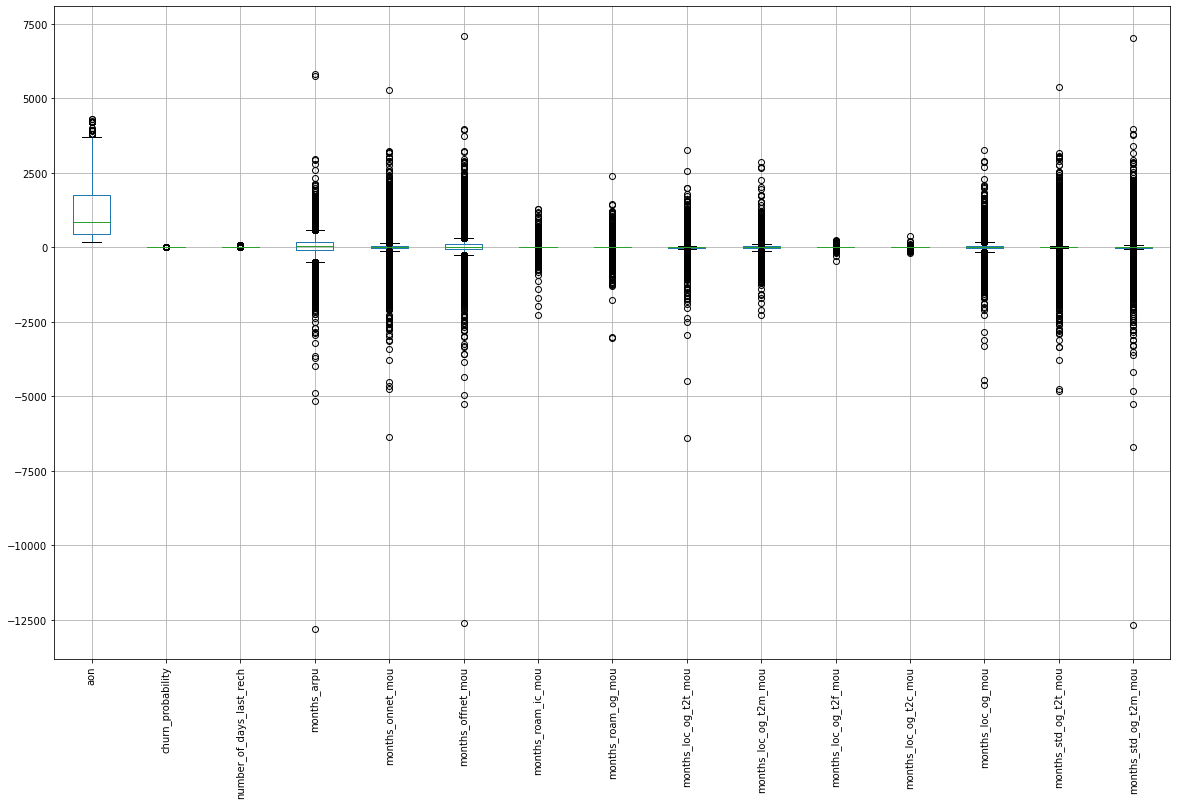

In [59]:
#plotting the box plots to identify the outliers
#plotting the boxplots for first 15 features
plt.figure(figsize = (20,12)) 
hv_cust.iloc[:,:15].boxplot()
plt.xticks(rotation=90)
plt.show()

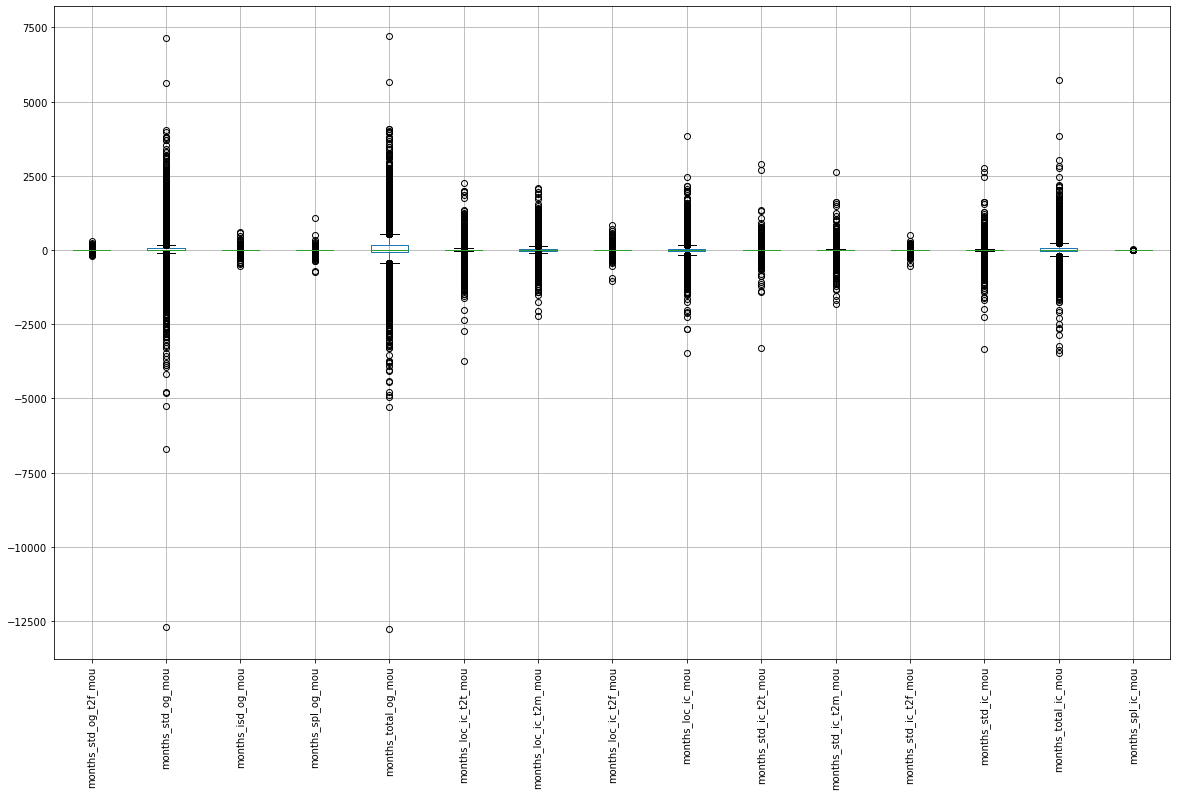

In [60]:
#plotting the boxplots for next 15 features
plt.figure(figsize = (20,12)) 
hv_cust.iloc[:,15:30].boxplot()
plt.xticks(rotation=90)
plt.show()

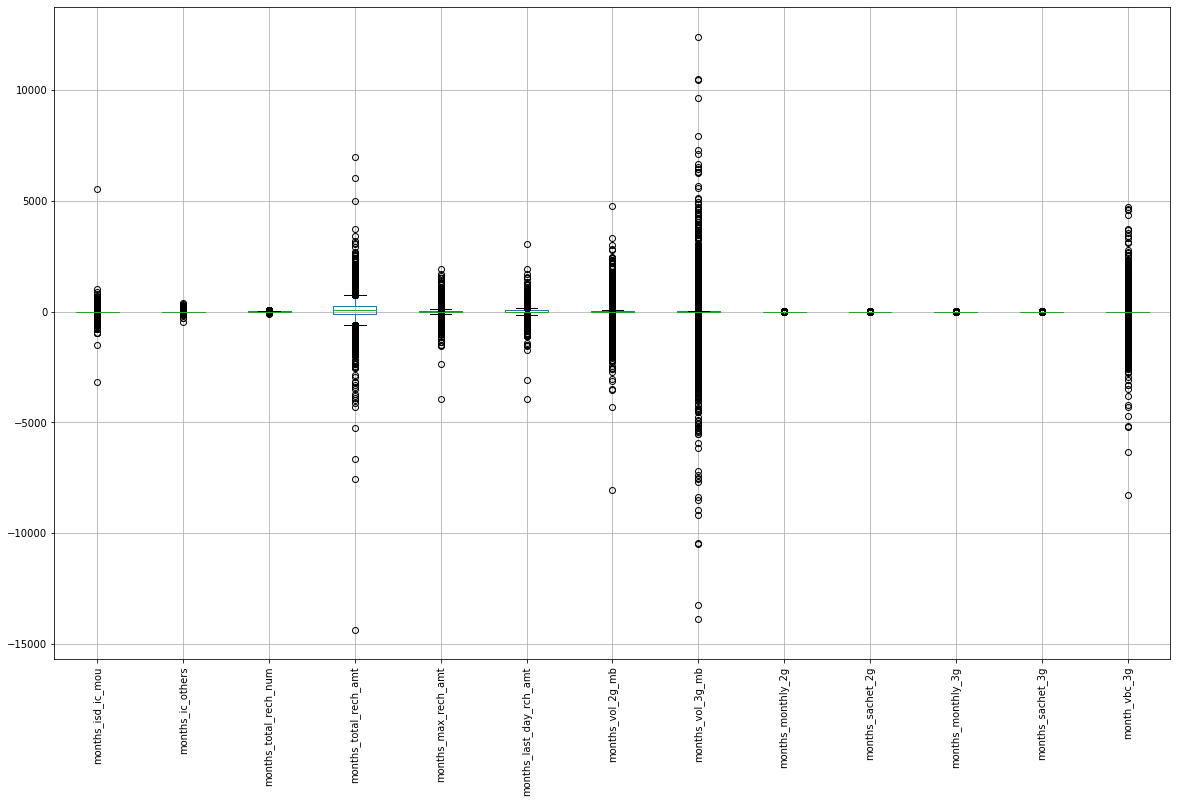

In [61]:
#plotting the boxplots for the remaining features
plt.figure(figsize = (20,12)) 
hv_cust.iloc[:,30:].boxplot()
plt.xticks(rotation=90)
plt.show()

**We can clearly see the outliers in the data. We will be fixing the outliers with the help of k-sigma method.**

In [62]:
#function to fix the outliers using k-sigma approach
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [63]:
#taking the target variable out and we don't want to remove any outliers from that
y_train_filtered1 = hv_cust.pop('churn_probability')

In [64]:
#applying the function on the dataset
hv_cust = hv_cust.apply(cap_outliers, axis=0)

In [65]:
#concatenating the independent and dependent features
hv_cust = pd.concat([hv_cust, y_train_filtered1], axis=1)

In [66]:
#displaying the top 5 rows of the dataset
hv_cust.head()

,aon,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,647.0,2.0,82.8845,6.925,37.920,26.82,7.865,1.365000,23.700,1.600,4.925,26.665,0.0,2.175,0.00,2.175,0.0,8.500,37.340,0.755000,-12.035,-1.570,-12.860,0.0,0.000,0.000,0.000,-12.860,0.000,0.0,0.000,3.5,91.0,15.5,-12.5,136.375,0.00,0.0,0.5,0.0,0.5,0.000,0
15,602.0,2.0,140.6355,-176.720,132.360,0.00,0.000,-176.720000,136.440,2.145,0.000,-38.135,0.0,0.000,-6.26,-6.260,0.0,0.040,-44.315,-302.956728,201.145,-7.915,-125.170,0.0,0.000,0.515,0.515,-124.655,0.000,0.0,0.000,0.0,-125.0,0.0,-175.0,-224.140,0.00,-0.5,0.0,0.0,0.0,0.000,0
23,455.0,10.0,538.4650,615.230,-15.125,0.00,0.000,412.113527,-125.800,9.625,0.000,499.055,0.0,101.040,0.00,101.040,0.0,0.015,600.100,145.065000,52.305,19.535,216.905,0.0,103.515,0.000,103.515,320.160,0.065,0.0,-0.325,12.5,711.0,-34.0,50.0,0.000,0.00,0.0,0.0,0.0,0.0,0.000,0
24,1219.0,2.0,121.5725,35.875,297.445,0.00,0.000,35.875000,89.505,0.000,-0.360,125.380,0.0,208.310,0.00,208.310,0.0,-0.360,333.330,26.025000,-12.070,-0.365,13.590,0.0,-13.680,0.000,-13.680,-0.080,0.000,0.0,0.000,-3.0,193.5,80.0,25.0,0.020,0.00,0.0,0.5,0.0,0.0,0.000,0
27,573.0,9.0,-50.5630,-2.650,-36.885,0.00,0.000,-2.650000,-34.055,-4.095,0.000,-40.800,0.0,1.265,0.00,1.265,0.0,0.000,-39.535,-15.025000,12.060,-30.455,-33.425,-0.4,0.000,7.715,7.315,-26.105,0.000,0.0,0.000,6.5,318.5,13.0,94.0,38.920,-1017.89,0.5,1.0,-1.0,-0.5,-520.685,0


### Validating the Correlation using heatmap

In [67]:
#taking the first half of the columns in the new variable
corr_first = hv_cust.columns[:23]
corr_first = corr_first.append(hv_cust.columns[-1:])
corr_first

Index(['aon', 'number_of_days_last_rech', 'months_arpu', 'months_onnet_mou',
       'months_offnet_mou', 'months_roam_ic_mou', 'months_roam_og_mou',
       'months_loc_og_t2t_mou', 'months_loc_og_t2m_mou',
       'months_loc_og_t2f_mou', 'months_loc_og_t2c_mou', 'months_loc_og_mou',
       'months_std_og_t2t_mou', 'months_std_og_t2m_mou',
       'months_std_og_t2f_mou', 'months_std_og_mou', 'months_isd_og_mou',
       'months_spl_og_mou', 'months_total_og_mou', 'months_loc_ic_t2t_mou',
       'months_loc_ic_t2m_mou', 'months_loc_ic_t2f_mou', 'months_loc_ic_mou',
       'churn_probability'],
      dtype='object')

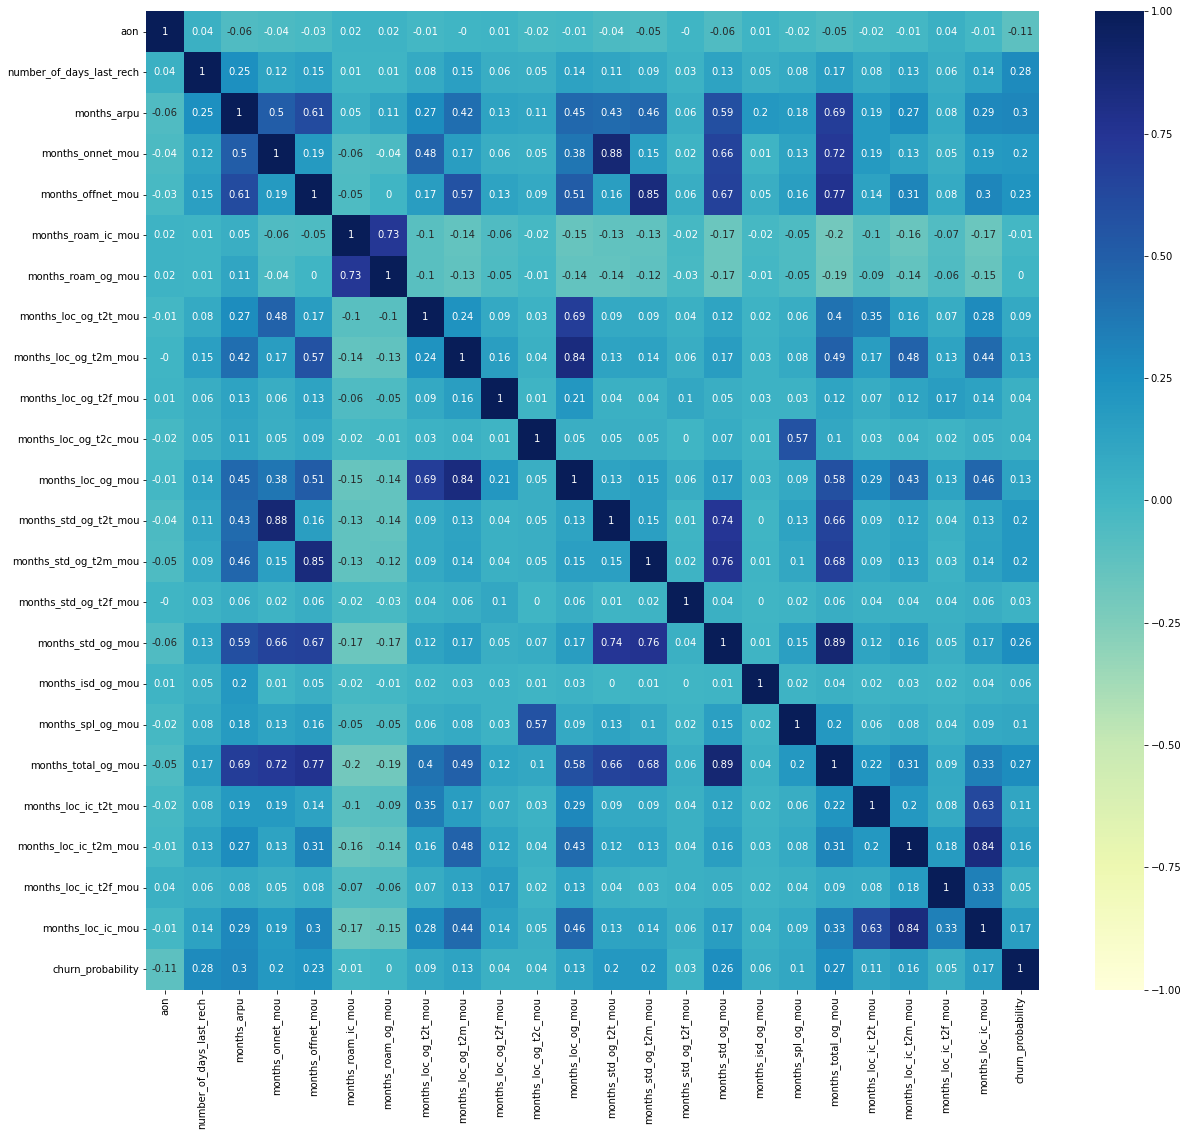

In [68]:
#plotting the corelation using heatmap for the first half of the features
plt.figure(figsize = (20,18))
sns.heatmap(round(hv_cust[corr_first].corr(),2), cmap="YlGnBu", vmin=-1.0,vmax=1.0, annot = True)
plt.show()

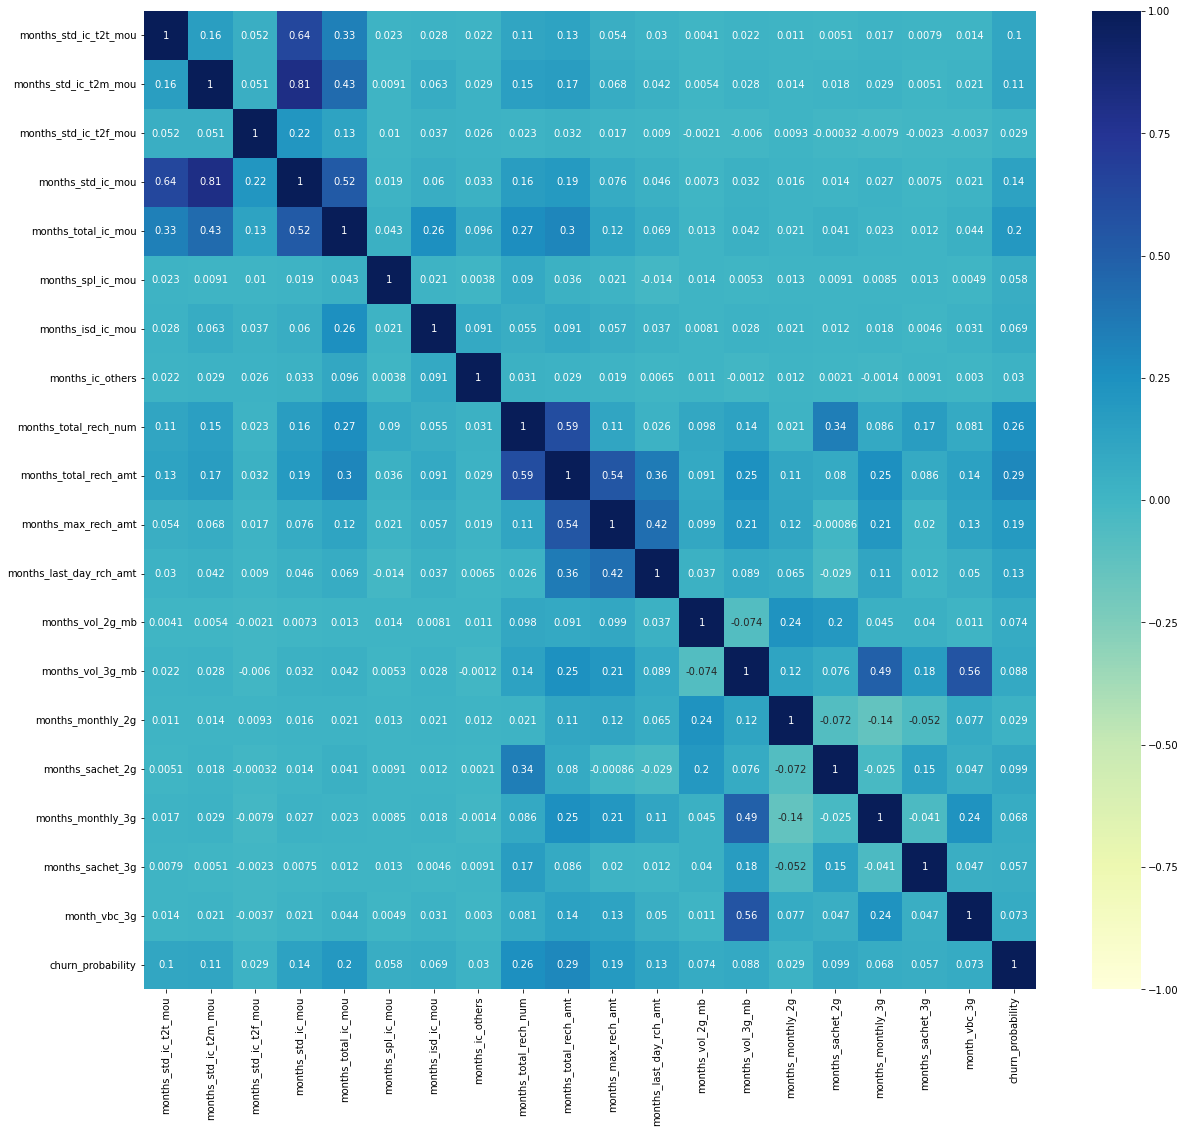

In [69]:
#plotting the corelation using heatmap for the remaining features
plt.figure(figsize = (20,18))
sns.heatmap(hv_cust.iloc[:,23:].corr(), cmap="YlGnBu", vmin=-1.0,vmax=1.0, annot = True)
plt.show()

**Inference:**
- months_onnet_mou is highly correlated with months)std_og_t2t_mou
- months_total_og_mou is highly correlated with months_std_og_mou
- month data of local calls is not much correlated with any other feature
- data recharge, phone recharge, special recharge are not much correlated with other features
- month data with std or isd are more likely be correlated with other features

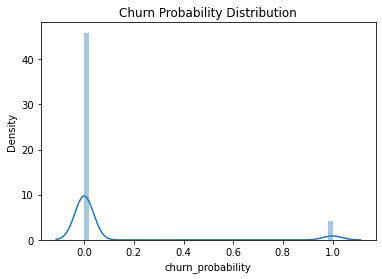

In [70]:
#checking the distribution of the target variable
plt.title('Churn Probability Distribution')
sns.distplot(hv_cust['churn_probability'])
plt.show()

**We can clearly see from the plot that the target variable is highly class imbalance. Before building the model, we need to handle this class imbalance issue. For this, we will be using the SMOTE method.**

In [71]:
hv_cust.churn_probability.value_counts()/len(hv_cust.index)*100

0    91.737308
1     8.262692
Name: churn_probability, dtype: float64

In [72]:
hv_cust.churn_probability.value_counts()

0    19263
1     1735
Name: churn_probability, dtype: int64

In [73]:
hv_cust.head()

,aon,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g,churn_probability
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,647.0,2.0,82.8845,6.925,37.920,26.82,7.865,1.365000,23.700,1.600,4.925,26.665,0.0,2.175,0.00,2.175,0.0,8.500,37.340,0.755000,-12.035,-1.570,-12.860,0.0,0.000,0.000,0.000,-12.860,0.000,0.0,0.000,3.5,91.0,15.5,-12.5,136.375,0.00,0.0,0.5,0.0,0.5,0.000,0
15,602.0,2.0,140.6355,-176.720,132.360,0.00,0.000,-176.720000,136.440,2.145,0.000,-38.135,0.0,0.000,-6.26,-6.260,0.0,0.040,-44.315,-302.956728,201.145,-7.915,-125.170,0.0,0.000,0.515,0.515,-124.655,0.000,0.0,0.000,0.0,-125.0,0.0,-175.0,-224.140,0.00,-0.5,0.0,0.0,0.0,0.000,0
23,455.0,10.0,538.4650,615.230,-15.125,0.00,0.000,412.113527,-125.800,9.625,0.000,499.055,0.0,101.040,0.00,101.040,0.0,0.015,600.100,145.065000,52.305,19.535,216.905,0.0,103.515,0.000,103.515,320.160,0.065,0.0,-0.325,12.5,711.0,-34.0,50.0,0.000,0.00,0.0,0.0,0.0,0.0,0.000,0
24,1219.0,2.0,121.5725,35.875,297.445,0.00,0.000,35.875000,89.505,0.000,-0.360,125.380,0.0,208.310,0.00,208.310,0.0,-0.360,333.330,26.025000,-12.070,-0.365,13.590,0.0,-13.680,0.000,-13.680,-0.080,0.000,0.0,0.000,-3.0,193.5,80.0,25.0,0.020,0.00,0.0,0.5,0.0,0.0,0.000,0
27,573.0,9.0,-50.5630,-2.650,-36.885,0.00,0.000,-2.650000,-34.055,-4.095,0.000,-40.800,0.0,1.265,0.00,1.265,0.0,0.000,-39.535,-15.025000,12.060,-30.455,-33.425,-0.4,0.000,7.715,7.315,-26.105,0.000,0.0,0.000,6.5,318.5,13.0,94.0,38.920,-1017.89,0.5,1.0,-1.0,-0.5,-520.685,0


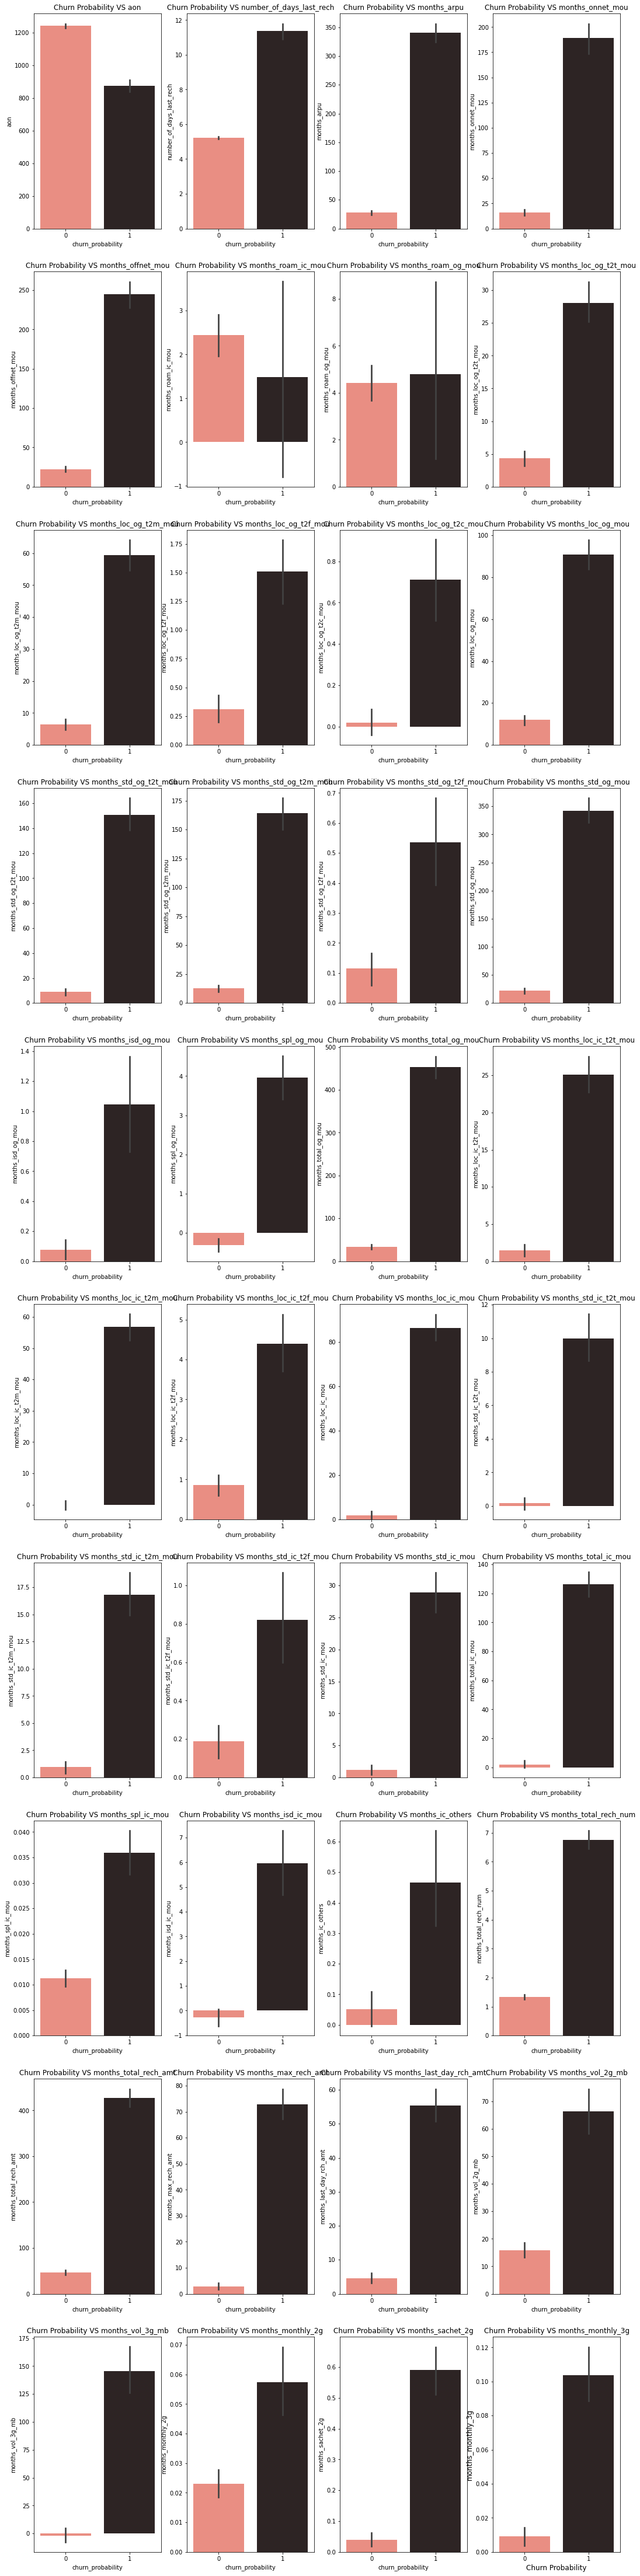

In [74]:
#checking the barplot corresponding to each feature with respect to churn and non-churn
churn_num = hv_cust.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(10,4,figsize=(18,80))
for i,ax in zip(churn_num.columns,axs.flatten()):
    sns.barplot(x=churn_num.churn_probability, y=i,data=churn_num,ax=ax,palette='dark:salmon_r')
    plt.xlabel('Churn Probability',fontsize=12)
    plt.ylabel(i,fontsize=12)
    ax.set_title('Churn Probability'+' VS '+str(i))

### Inferences:-
  - The customer who have high age on network means old customers are likely to less churn probability than new the customers. 
  - Customer who have recently recharge have less churn probabilty than customer who didn't recharge from long time.
  - Customer who didn't recharge data from long term likely to their  churn probability is high.
  - Customer whose average revenue per user is high likely to high churn probability which is a concern for the companyand they have to take action to stop them to churn.
  - Roaming incoming user have likely to less churn probability. The reason could be they are not in the region so can't churn.
  - Roaming outgoing users have likely to high churn probability. The reason could be if they are making more std calls, it might be costly for them.
  - Churn probability is high for those customers whose minute of usage in month less using minute on call.
  - Churn probabilty is high for those customer whose number of recharge decresed in month action.
  - Customer who does not do monthly recharge more when they in the action phase, the churn probability is more whose volume based action month is increased.
  - Churn probability rate is high for customers whose amount of recharge in action phase is lesser.
  - Churn probability is more for customer whose recharge amount is decreasing.
  - Churn probability is more for the customer whose recharge amount as well as number of recharge decreased.

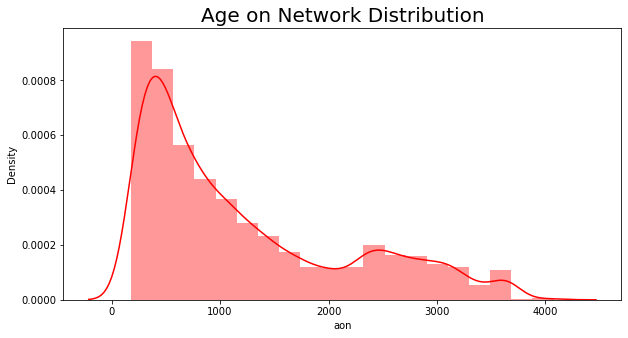

In [75]:
# Describing aon : the Age on Network Distribution
plt.figure(figsize = (10,5))
sns.distplot(hv_cust.aon, bins=20, color="r")
plt.title("Age on Network Distribution", fontsize=20)
plt.show()

### Inference:-
  - We can notice that the customer who have high age on network means old customers are likely to less churn probability than new customers.
  - Minimum age of customer on network is 180 days.
  - Maximum age of customer on network is around 4000 days.

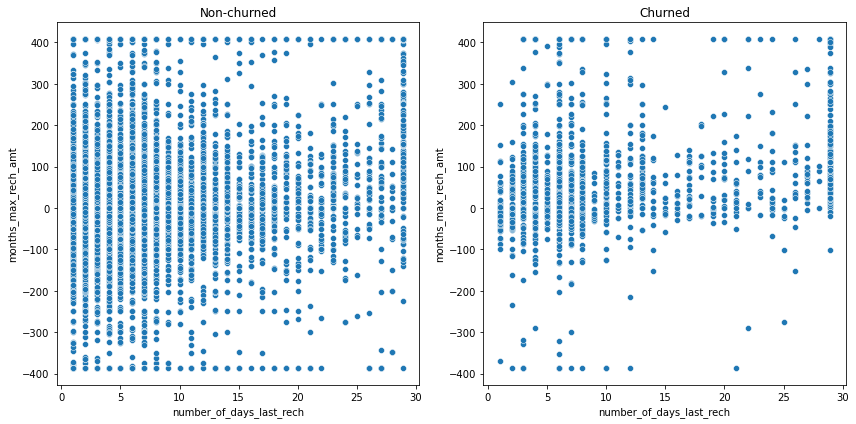

In [76]:
#plotting the scatter plot to check the relationship between maximum recharge amount and last day recharge
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")
sns.scatterplot(hv_cust[hv_cust["churn_probability"] == 0]['number_of_days_last_rech'], hv_cust[hv_cust["churn_probability"] == 0]['months_max_rech_amt'], ax=ax1)
sns.scatterplot(hv_cust[hv_cust["churn_probability"] == 1]['number_of_days_last_rech'], hv_cust[hv_cust["churn_probability"] == 1]['months_max_rech_amt'], ax=ax2)
plt.tight_layout()
plt.show()

### Inference:-
 - Months maximum recharge amount and number of day last recharge are most likely to scatter across positive for churned customers.
 - Means drop in maximum recharge amount in month and number of last day recharge in action phase can signify customer churn.
    

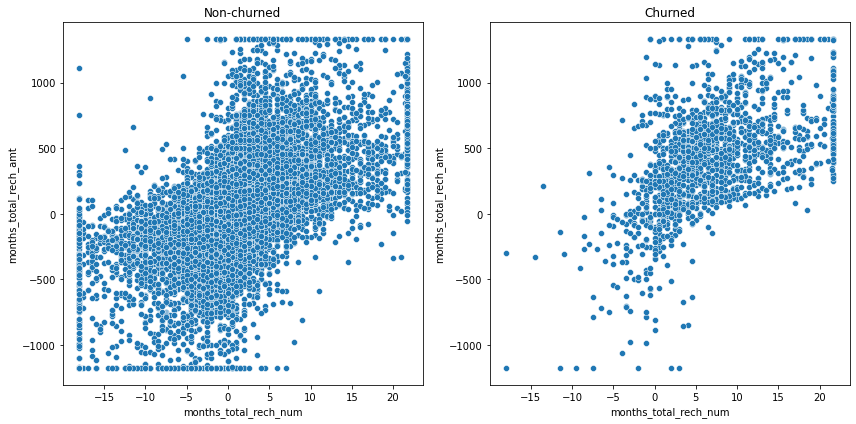

In [77]:
#plotting the scatter plot to check the relationship between total number of recharges and total recharge amount
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1, title="Non-churned")
ax2 = fig.add_subplot(1, 2, 2, title="Churned")
sns.scatterplot(hv_cust[hv_cust["churn_probability"] == 0]['months_total_rech_num'], hv_cust[hv_cust["churn_probability"] == 0]['months_total_rech_amt'], ax=ax1)
sns.scatterplot(hv_cust[hv_cust["churn_probability"] == 1]['months_total_rech_num'], hv_cust[hv_cust["churn_probability"] == 1]['months_total_rech_amt'], ax=ax2)
plt.tight_layout()
plt.show()

### Inference:-
 - Here positive correlation between months total recharge amount and months total number of recharge.
 - Positive value of the features means recharge amount value dropped from good phase of action.
 - Negative value of the features means recharge amount value increase from good phase to action phase.
 - By comparing both churned and not churned customer we can observe that churned customer both recharge amount and number of recharge dropped in action phase.

#### Train Test Split

In [78]:
#importing the required library for spliting the test and train data
import sklearn
from sklearn.model_selection import train_test_split

In [79]:
#creating X and y attributes for analysis
X = hv_cust.drop(['churn_probability'], axis=1)
y = hv_cust[['churn_probability']]

In [80]:
#creating X_train, y_train, X_test and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [81]:
X_train.head()

,aon,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56802,2497.0,6.0,152.7860,118.455,175.540,0.0,0.0,28.950,43.545000,0.000,0.140,72.490,89.510,131.435,0.175,221.110,0.25,0.140,294.000,64.685,43.315,9.18,117.185,11.095,30.770,0.000,41.865,159.060,0.0,0.000,0.000,4.5,360.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000
51457,560.0,1.0,1025.8770,321.895,-31.050,0.0,0.0,169.370,-85.685000,-14.460,-10.315,69.235,152.515,87.435,-10.630,229.315,0.00,-40.415,259.785,234.055,10.365,-0.29,244.135,88.060,50.855,-4.710,134.205,378.550,0.0,0.215,0.000,5.5,1314.0,323.500000,222.500000,59.395,1911.324271,0.5,0.0,1.437629,0.0,184.445
17983,1623.0,1.0,-500.5745,369.605,-710.960,0.0,0.0,369.605,-425.499077,-0.815,0.000,-342.265,0.000,-0.830,0.000,-0.830,0.00,2.005,-341.090,-46.930,49.580,0.63,3.285,0.000,5.710,-0.260,5.440,6.955,0.0,0.000,-1.775,6.0,1289.0,408.360202,422.759938,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000
57074,1103.0,1.0,-155.7705,0.000,0.000,0.0,0.0,0.000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,3.265,34.890,0.00,38.160,0.465,0.000,0.000,0.465,35.095,0.0,-3.520,0.000,-1.0,-229.0,0.000000,-176.000000,-110.820,-276.635000,0.0,0.5,-1.411865,1.0,-468.855
37968,635.0,2.0,7.6480,-9.740,-10.855,0.0,0.0,-9.740,-11.760000,0.000,0.905,-21.495,0.000,0.000,0.000,0.000,0.00,-4.135,-25.640,-46.120,-52.725,-15.16,-114.015,0.000,0.000,-2.785,-2.785,-116.775,0.0,0.025,0.000,-1.5,18.5,11.000000,10.500000,-1.030,730.855000,0.0,-2.5,0.500000,2.5,184.680


In [82]:
#checking the shape of all the new dfs
print("X_train ", X_train.shape)
print("y_train ", y_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

X_train  (16798, 42)
y_train  (16798, 1)
X_test  (4200, 42)
y_test  (4200, 1)


#### Performing Feature Scaling

In [83]:
X_train_col = X_train.columns

In [84]:
X_train_col

Index(['aon', 'number_of_days_last_rech', 'months_arpu', 'months_onnet_mou',
       'months_offnet_mou', 'months_roam_ic_mou', 'months_roam_og_mou',
       'months_loc_og_t2t_mou', 'months_loc_og_t2m_mou',
       'months_loc_og_t2f_mou', 'months_loc_og_t2c_mou', 'months_loc_og_mou',
       'months_std_og_t2t_mou', 'months_std_og_t2m_mou',
       'months_std_og_t2f_mou', 'months_std_og_mou', 'months_isd_og_mou',
       'months_spl_og_mou', 'months_total_og_mou', 'months_loc_ic_t2t_mou',
       'months_loc_ic_t2m_mou', 'months_loc_ic_t2f_mou', 'months_loc_ic_mou',
       'months_std_ic_t2t_mou', 'months_std_ic_t2m_mou',
       'months_std_ic_t2f_mou', 'months_std_ic_mou', 'months_total_ic_mou',
       'months_spl_ic_mou', 'months_isd_ic_mou', 'months_ic_others',
       'months_total_rech_num', 'months_total_rech_amt', 'months_max_rech_amt',
       'months_last_day_rch_amt', 'months_vol_2g_mb', 'months_vol_3g_mb',
       'months_monthly_2g', 'months_sachet_2g', 'months_monthly_3g',
      

In [85]:
#instantiate an object for scaling
scaler = StandardScaler()

#scale the train data using fit_transform and test data using transform
X_train[X_train_col] = scaler.fit_transform(X_train[X_train_col])
X_test[X_train_col]= scaler.transform(X_test[X_train_col])

In [86]:
#validating the train data to make sure scaling worked correctly
X_train.describe()

,aon,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g
count,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04,1.679800e+04
mean,1.059398e-16,8.350697e-16,-5.277492e-18,1.115643e-16,6.758626e-17,3.825603e-17,-4.710996e-16,6.640982e-17,3.010517e-17,1.428921e-17,-6.883013e-16,4.290730e-17,-4.001690e-16,-5.940227e-16,-1.010108e-15,1.836233e-16,-1.497391e-15,1.642731e-17,9.982292e-17,7.451937e-17,1.108290e-17,-1.798197e-16,1.291118e-17,-3.703848e-16,7.478540e-17,5.498373e-16,-5.598041e-17,-1.496997e-17,3.098750e-16,7.645721e-16,1.173794e-15,-8.639621e-17,-4.241160e-17,-2.602478e-17,8.003810e-17,-5.582827e-16,-1.378675e-16,3.490101e-16,-9.776851e-16,-3.864358e-16,4.456201e-16,-2.004257e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.079137e+00,-7.739438e-01,-3.526334e+00,-3.980186e+00,-3.837985e+00,-5.196816e+00,-4.876259e+00,-5.242789e+00,-3.895129e+00,-4.535598e+00,-4.684734e+00,-3.851327e+00,-4.187203e+00,-4.293271e+00,-5.930649e+00,-3.801824e+00,-9.051245e+00,-4.905944e+00,-3.534962e+00,-5.424807e+00,-3.997487e+00,-4.903642e+00,-3.945928e+00,-6.706508e+00,-5.560295e+00,-6.134717e+00,-5.201382e+00,-3.868273e+00,-4.399591e+00,-7.356175e+00,-7.491361e+00,-3.413362e+00,-3.488563e+00,-3.989106e+00,-3.863358e+00,-4.098816e+00,-4.150665e+00,-3.328093e+00,-3.606417e+00,-3.730350e+00,-5.207991e+00,-4.064186e+00
25%,-7.839434e-01,-6.094137e-01,-4.735348e-01,-2.112443e-01,-3.003888e-01,-6.602871e-02,-7.927744e-02,-1.877552e-01,-2.876231e-01,-7.923857e-02,-1.704041e-02,-2.998567e-01,-1.087155e-01,-1.416355e-01,-4.148126e-02,-1.700173e-01,-3.633017e-02,-1.132536e-01,-3.234575e-01,-2.282731e-01,-3.142194e-01,-1.403429e-01,-3.278652e-01,-4.780686e-02,-1.349453e-01,-3.765869e-02,-1.534075e-01,-3.333411e-01,-1.105892e-01,-5.530607e-03,-2.051083e-02,-4.787645e-01,-4.953137e-01,-3.408951e-01,-3.151284e-01,-1.079399e-01,-1.984221e-02,-8.240003e-02,-5.358825e-02,-4.325089e-02,-5.263951e-02,-1.313344e-03
50%,-3.721432e-01,-2.803534e-01,-4.310938e-02,-1.178773e-01,-1.112524e-01,-6.602871e-02,-7.927744e-02,-6.828338e-02,-6.744615e-02,-5.402803e-02,-1.704041e-02,-8.385934e-02,-1.061628e-01,-1.219360e-01,-4.148126e-02,-1.442179e-01,-3.633017e-02,-2.384463e-04,-1.291713e-01,-4.166293e-02,-2.500363e-02,-6.548610e-02,-3.782780e-02,-3.423323e-

In [87]:
#validating the train data to make sure scaling worked correctly
X_test.describe()

,aon,number_of_days_last_rech,months_arpu,months_onnet_mou,months_offnet_mou,months_roam_ic_mou,months_roam_og_mou,months_loc_og_t2t_mou,months_loc_og_t2m_mou,months_loc_og_t2f_mou,months_loc_og_t2c_mou,months_loc_og_mou,months_std_og_t2t_mou,months_std_og_t2m_mou,months_std_og_t2f_mou,months_std_og_mou,months_isd_og_mou,months_spl_og_mou,months_total_og_mou,months_loc_ic_t2t_mou,months_loc_ic_t2m_mou,months_loc_ic_t2f_mou,months_loc_ic_mou,months_std_ic_t2t_mou,months_std_ic_t2m_mou,months_std_ic_t2f_mou,months_std_ic_mou,months_total_ic_mou,months_spl_ic_mou,months_isd_ic_mou,months_ic_others,months_total_rech_num,months_total_rech_amt,months_max_rech_amt,months_last_day_rch_amt,months_vol_2g_mb,months_vol_3g_mb,months_monthly_2g,months_sachet_2g,months_monthly_3g,months_sachet_3g,month_vbc_3g
count,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000
mean,0.016048,0.024929,-0.000697,-0.010304,-0.014552,-0.006915,-0.009654,0.003330,0.009138,0.003692,0.000365,0.009080,-0.007083,-0.022622,-0.008296,-0.017649,-0.019263,0.016063,-0.012589,0.006243,0.008401,-0.009724,0.004793,0.010967,-0.018143,0.008379,0.003340,0.006237,0.012817,0.019717,0.009933,0.005174,-0.003857,-0.011387,0.003180,-0.007402,0.014431,-0.008228,0.008630,0.005988,0.004095,0.005833
std,1.012955,1.013486,1.000988,1.025522,0.969529,0.968483,0.988720,0.982060,1.002839,1.024734,1.019258,0.982627,1.029722,0.962498,1.044424,0.998108,0.973959,1.008686,0.985825,1.054256,1.014131,0.990996,1.026588,0.998814,1.024103,0.991438,1.009907,1.032482,1.011364,0.970703,1.026845,1.002798,0.990908,0.997133,0.999309,0.987072,0.986423,1.031692,1.009219,1.029364,0.989009,0.964995
min,-1.079137,-0.773944,-3.526334,-3.980186,-3.837985,-5.196816,-4.876259,-5.242789,-3.895129,-4.535598,-4.684734,-3.851327,-4.187203,-4.293271,-5.930649,-3.801824,-9.051245,-4.905944,-3.534962,-5.424807,-3.997487,-4.903642,-3.945928,-6.706508,-5.560295,-6.134717,-5.201382,-3.868273,-4.399591,-7.356175,-7.491361,-3.413362,-3.488563,-3.989106,-3.863358,-4.098816,-4.150665,-3.328093,-3.606417,-3.730350,-5.207991,-4.064186
25%,-0.780792,-0.609414,-0.468566,-0.207284,-0.308558,-0.066029,-0.079277,-0.173775,-0.285412,-0.095433,-0.017040,-0.293891,-0.108894,-0.140066,-0.041481,-0.167860,-0.036330,-0.095409,-0.321321,-0.223469,-0.291653,-0.139927,-0.319294,-0.044979,-0.134253,-0.037659,-0.145361,-0.337964,-0.110589,-0.005531,-0.020511,-0.478764,-0.481457,-0.330830,-0.305793,-0.107940,-0.019842,-0.082400,-0.053588,-0.043251,-0.052640,-0.001313
50%,-0.364790,-0.280353,-0.033451,-0.117599,-0.114959,-0.066029,-0.079277,-0.065043,-0.067714,-0.054028,-0.017040,-0.081227,-0.106163,-0.121842,-0.041481,-0.143967,-0.036330,-0.000238,-0.132594,-0.041840,-0.024035,-0.065486,-0.037024,-0.034233,-0.058487,-0.037659,-0.049756,-0.043855,-0.110589,-0.005531,-0.020511,-0.047207,-0.049131,-0.089268,-0.081740,-0.107940,-0.019842,-0.082400,-0.053588,-0.043251,-0.052640,-0.001313
75%,0.643701,0.213237,0.465269,0.086071,0.227922,-0.066029,-0.079277,0.144093,0.262144,0.102912,0.062220,0.254838,-0.043074,0.007165,-0.041481,0.021319,-0.036330,0.227491,0.235591,0.219357,0.311335,0.115071,0.300629,0.090192,0.139650,-0.020459,0.161831,0.337673,-0.110589,-0.005531,-0.016596,0.384350,0.481577,0.229039,0.394374,-0.005802,-0.007885,-0.082400,-0.053588,-0.043251,-0.052640,-0.001313
max,3.012216,3.815435,3.514261,3.983014,3.841173,5.194921,4.875333,5.259997,3.918481,4.546948,4.669596,3.865555,4.201907,4.296630,5.953522,3.799315,9.039843,4.879214,3.530177,5.414872,4.007660,4.913041,3.953559,6.715824,5.553568,6.

### Handling class imbalance issue using SMOTE

In [88]:
#lets print stats before smote
y_train.value_counts()

churn_probability
0                    15410
1                     1388
dtype: int64

In [89]:
#instantiating the smote
smote = SMOTE(random_state=12)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [90]:
#lets print stats after smote
y_train_smote.value_counts()

churn_probability
0                    15410
1                    15410
dtype: int64

### Performing PCA for dimentionality reduction

In [91]:
#initializing pca
pca = PCA(svd_solver='randomized', random_state=42)

In [92]:
#lets fit PCA on the train dataset
pca.fit(X_train_smote)

PCA(random_state=42, svd_solver='randomized')

In [93]:
pca.components_

array([[ 4.16683208e-02, -1.45925621e-01, -3.02392924e-01, ...,
        -2.88526737e-02, -1.15616891e-02, -2.60896587e-02],
       [ 3.81208384e-02,  3.04671310e-01,  3.48269066e-02, ...,
         1.17257164e-01,  7.52704575e-02,  1.24785537e-01],
       [ 5.93869759e-02, -1.83112374e-01, -2.29372399e-01, ...,
        -1.52823525e-01, -5.93017108e-02, -1.23888527e-01],
       ...,
       [-2.73561534e-03, -4.06079342e-03, -2.98091917e-03, ...,
         1.62187021e-03,  1.49178121e-03,  1.94454710e-03],
       [-1.92815460e-03, -5.38736440e-04, -9.20615930e-03, ...,
         1.42833331e-03,  5.64628323e-04, -2.28717242e-03],
       [-2.77893338e-04, -8.35881968e-04,  7.68288888e-05, ...,
         2.09593596e-04, -2.99898682e-04,  1.04837049e-03]])

In [94]:
pca.explained_variance_ratio_

array([2.42007390e-01, 8.30549537e-02, 6.82497557e-02, 5.37651277e-02,
       4.62535728e-02, 4.41083260e-02, 3.99541744e-02, 3.39422852e-02,
       2.85934354e-02, 2.62707372e-02, 2.52980816e-02, 2.30075334e-02,
       2.06180919e-02, 2.00254841e-02, 1.95386709e-02, 1.83619956e-02,
       1.78446614e-02, 1.72444307e-02, 1.64048261e-02, 1.56630691e-02,
       1.55247558e-02, 1.49052515e-02, 1.38759296e-02, 1.35074869e-02,
       1.21868073e-02, 1.15449486e-02, 1.05693982e-02, 9.06786005e-03,
       8.55311637e-03, 7.39002798e-03, 6.95806009e-03, 4.85439147e-03,
       4.69466502e-03, 2.07116192e-03, 9.99169623e-04, 8.67129149e-04,
       6.34793671e-04, 5.35671978e-04, 4.66517960e-04, 2.59826446e-04,
       2.21633702e-04, 1.04794179e-04])

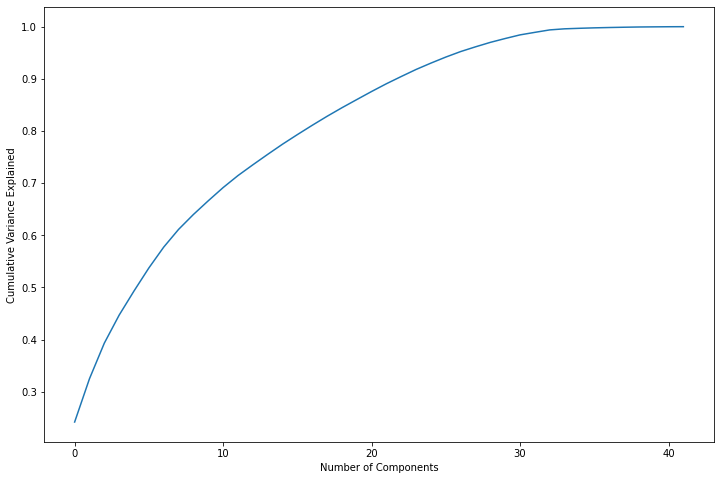

In [95]:
#lets draw screeplot in between cumulative variance and number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Cumulative Variance Explained")
plt.xlabel('Number of Components')
plt.show()

The plot is not providing any valuable information about the number of features. Lets look at below plot to get more details.

In [96]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

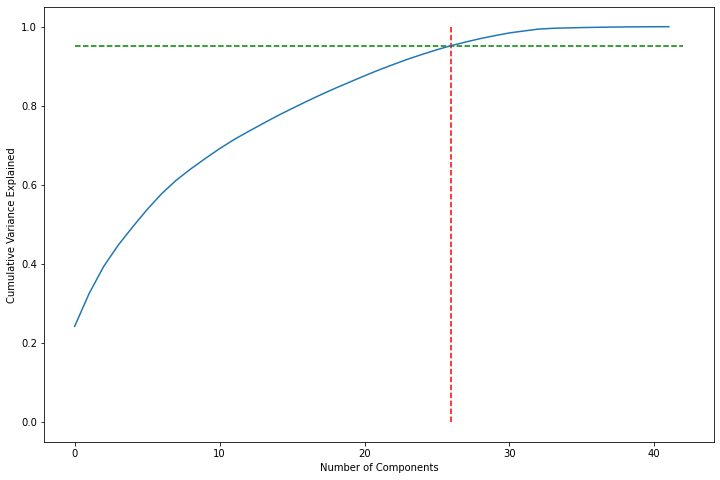

In [97]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=26, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=42, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative Variance Explained")
plt.xlabel('Number of Components')
plt.show()

**From the above plot, 26 components are enough to explain 95% variance. Let's build the Logistic Regression model with these features.**

In [98]:
#lets perform incremental PCA for efficiency 
pca_inc = IncrementalPCA(n_components=26)

In [99]:
#lets fit PCA on the train dataset
X_train_pca = pca_inc.fit_transform(X_train_smote)
X_train_pca.shape

(30820, 26)

In [100]:
#lets create correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.004962951529731393 , min corr:  -0.00633203412686631


It clearly shows that the correlation is close to 0.

In [101]:
#Applying selected components to the test data - 26 components
X_test_pca = pca_inc.transform(X_test)
X_test_pca.shape

(4200, 26)

## Building Predictor Model - Logistic Regression

In [102]:
#function to get the confusion metrics, accuracy score and recall/sensitivity score
def model_score(y_test, y_pred):
    confusion = metrics.confusion_matrix(y_test, y_pred)
    TP = confusion[1,1] 
    TN = confusion[0,0] 
    FP = confusion[0,1] 
    FN = confusion[1,0] 

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    recall_score = TP / float(TP+FN)
    precision = TP / float(TP+FP)
    f1_score = 2 * (precision * recall_score) / (precision + recall_score)
    return accuracy_score, recall_score, f1_score

In [103]:
#taking accuracy and recall dataframe with 0 values for getting multiple cutoff values and their respective results
accuracy_met = pd.DataFrame(data=np.zeros((7,1)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[26])
recall_met = pd.DataFrame(data=np.zeros((7,1)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[26])
F1_met = pd.DataFrame(data=np.zeros((7,1)),index=[0.2,0.3,0.4,0.5,0.6,0.7,0.8], columns=[26])

In [104]:
#adding the constant value for both train and test datasets before building the model
X_train_sm = sm.add_constant(X_train_pca)
X_test_sm = sm.add_constant(X_test_pca)
logm2 = sm.GLM(y_train_smote,X_train_sm, family = sm.families.Binomial())
result = logm2.fit()  #fitting the model

#predicting the results
y_test_pred_lr = result.predict(X_test_sm)

df = pd.DataFrame()
df['true_value'] = y_test.values.reshape(-1)
df['pred_prob_value'] = y_test_pred_lr.reshape(-1) # predicted probability of churned

for cutoff in [float(x)/10 for x in range(2, 9)]:
    col_name = 'pred_value' + str(cutoff)
    df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0)
    accuracy_met.loc[cutoff, 26], recall_met.loc[cutoff, 26], F1_met.loc[cutoff, 26] = model_score(y_test, df[col_name])

In [105]:
#displaying the recall metrics for multiple cuts
recall_met

,26
0.2,0.910663
0.3,0.861671
0.4,0.824207
0.5,0.786744
0.6,0.711816
0.7,0.602305
0.8,0.484150


In [106]:
#displaying the accuracy metrics for multiple cuts
accuracy_met

,26
0.2,0.469048
0.3,0.625476
0.4,0.733810
0.5,0.813095
0.6,0.860714
0.7,0.889762
0.8,0.912619


In [107]:
#displaying the F1 metrics for multiple cuts
F1_met

,26
0.2,0.220825
0.3,0.275449
0.4,0.338462
0.5,0.410218
0.6,0.457831
0.7,0.474461
0.8,0.477952


**By looking at both the tables above, 0.4 cutoff looks good as it gives more recall value than accuracy. Also the difference between recall and accuracy is minimal. Below is the score of Accuracy and Recall.**

**Recall/Sensitivity: 0.82**<br>
**Accuracy: 0.73**

### Decision Tree Model
**Now we will try the decision tree model and find the best estimator using hyperparameter tuning.**

In [108]:
#importing the required libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [109]:
#?DecisionTreeClassifier

In [110]:
#finding the best values using grid search
decisionTree = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'min_samples_split': [10, 20, 30, 50, 100],
    'min_samples_leaf': [10, 20, 30, 50, 100],
    'criterion': ["gini"]
}
grid_search_decision_tree = GridSearchCV(estimator=decisionTree, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "recall")
grid_search_decision_tree.fit(X_train_pca, y_train_smote)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [10, 20, 30, 50, 100],
                         'min_samples_split': [10, 20, 30, 50, 100]},
             scoring='recall', verbose=1)

In [111]:
#displaying the best parameters
grid_search_decision_tree.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [112]:
#building the model using best estimaors
decisionTree_final = grid_search_decision_tree.best_estimator_
decisionTree_final.fit(X_train_pca, y_train_smote)
y_train_pred_decisionTree = decisionTree_final.predict(X_train_pca)
y_test_pred_decisionTree = decisionTree_final.predict(X_test_pca)
print(y_test_pred_decisionTree)

[1 0 0 ... 0 0 0]


In [113]:
#displaying the accuracy and recall values
print("Performance of Decision Tree Classifier on training data")
accuracy_score, recall_score, F1_score = model_score(y_train_smote, y_train_pred_decisionTree)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of Decision Tree Classifier on training data
Recall :  0.9216742375081116
Accuracy :  0.8889033095392602
F1 Score :  0.8924285265472826


In [114]:
#displaying the accuracy and recall values
print("Performance of Decision Tree Classifier on test data")
accuracy_score, recall_score, F1_score = model_score(y_test, y_test_pred_decisionTree)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of Decision Tree Classifier on test data
Recall :  0.6974063400576369
Accuracy :  0.7971428571428572
F1 Score :  0.36227544910179643


**By looking at the score of Recall and accuracy, it looks that model has done decent job. Below is the score of Accuracy and Recall.**

#### Training Data:

*Recall/Sensitivity:* **0.92**<br>
*Accuracy:* **0.89**

#### Test Data:

*Recall/Sensitivity:* **0.70**<br>
*Accuracy:* **0.8**

### Random Forest Model
**Now we will try the random forest model and find the best estimator using hyperparameter tuning.**

In [115]:
#importing the required libraries
from sklearn.ensemble import RandomForestClassifier

In [116]:
#finding the best values using grid search
randomForest = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [4, 5, 6],
    'n_estimators': [50, 100]
}

grid_search_random_forest = GridSearchCV(estimator=randomForest, 
                           param_grid=params, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring = "recall")

grid_search_random_forest.fit(X_train_pca,y_train_smote)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'max_features': [4, 5, 6],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [50, 100]},
             scoring='recall', verbose=1)

In [117]:
#displaying the best parameters
grid_search_random_forest.best_estimator_

RandomForestClassifier(max_depth=30, max_features=6, min_samples_leaf=5,
                       n_jobs=-1, random_state=42)

In [118]:
#building the model using best estimaors
randomForest_final = grid_search_random_forest.best_estimator_
randomForest_final.fit(X_train_pca, y_train_smote)
y_train_pred_randomForest = randomForest_final.predict(X_train_pca)
y_test_pred_randomForest = randomForest_final.predict(X_test_pca)
print(y_test_pred_randomForest)

[0 0 0 ... 0 0 0]


In [119]:
#displaying the accuracy and recall values
print("Performance of Random Forest Classifier on training data")
accuracy_score, recall_score, F1_score = model_score(y_train_smote, y_train_pred_randomForest)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of Random Forest Classifier on training data
Recall :  0.9926022063595068
Accuracy :  0.9850097339390006
F1 Score :  0.9851226895085978


In [120]:
#displaying the accuracy and recall values
print("Performance of Random Forest Classifier on test data")
accuracy_score, recall_score, F1_score = model_score(y_test, y_test_pred_randomForest)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of Random Forest Classifier on test data
Recall :  0.6051873198847262
Accuracy :  0.8957142857142857
F1 Score :  0.48951048951048953


**By looking at the score of Recall and accuracy, it looks that model has done decent job. Below is the score of Accuracy and Recall.**

#### Training Data:

*Recall/Sensitivity:* **0.99**<br>
*Accuracy:* **0.99**

#### Test Data:

*Recall/Sensitivity:* **0.61**<br>
*Accuracy:* **0.90**

### AdaBoost
**Now we will try the  AdaBoost model and find the best estimator using hyperparameter tuning.**

In [121]:
#importing the required libraries
from sklearn.ensemble import AdaBoostClassifier

In [122]:
#create the first basic decision tree as a weak learner
basic_tree = DecisionTreeClassifier(max_depth=2, random_state = 42)

#fit the basic decision tree 
basic_tree.fit(X_train_pca, y_train_smote)

#get the test error
y_pred = basic_tree.predict(X_test_pca)
score = metrics.accuracy_score(y_test, y_pred)
score

0.7416666666666667

In [123]:
estimators = list(range(1, 150, 10))

#find the best estimators using loop
adaboost = []
for num_est in estimators:
    adaboostClassifier = AdaBoostClassifier(base_estimator=basic_tree, n_estimators = num_est, random_state=42)
    
    adaboostClassifier.fit(X_train_pca, y_train_smote)
    y_pred_ada = adaboostClassifier.predict(X_test_pca)
    score = metrics.accuracy_score(y_test, y_pred_ada)
    adaboost.append(score)

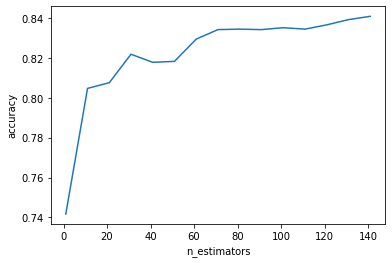

In [124]:
# Plot the scores corrosponding to number of estimators to find the best possible number of estimator
plt.plot(estimators, adaboost)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()

In [125]:
#building the model using best estimaors
adaboost_final = AdaBoostClassifier(base_estimator=basic_tree, n_estimators = 120, random_state=42)
adaboost_final.fit(X_train_pca, y_train_smote)
y_pred = adaboost_final.predict(X_test_pca)
y_train_pred_adaboost = adaboost_final.predict(X_train_pca)
y_test_pred_adaboost = adaboost_final.predict(X_test_pca)

In [126]:
#displaying the accuracy and recall values
print("Performance of AdaBoost Classifier on training data")
accuracy_score, recall_score, F1_score = model_score(y_train_smote, y_train_pred_adaboost)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of AdaBoost Classifier on training data
Recall :  0.8858533419857235
Accuracy :  0.8817326411421155
F1 Score :  0.8822179855882637


In [127]:
#displaying the accuracy and recall values
print("Performance of AdaBoost Classifier on test data")
accuracy_score, recall_score, F1_score = model_score(y_test, y_test_pred_adaboost)
print("Recall : ", recall_score)
print("Accuracy : ", accuracy_score)
print("F1 Score : ", F1_score)

Performance of AdaBoost Classifier on test data
Recall :  0.69164265129683
Accuracy :  0.8369047619047619
F1 Score :  0.4120171673819743


**By looking at the score of Recall and accuracy, it looks that model has done decent job. Below is the score of Accuracy and Recall.**

#### Training Data:

*Recall/Sensitivity:* **0.89**<br>
*Accuracy:* **0.88**

#### Test Data:

*Recall/Sensitivity:* **0.69**<br>
*Accuracy:* **0.84**

<hr></hr>

### Summary of all the predictor models:
<table>
    <th>
        <tr>
            <td rowspan='2'>Model</td>
            <td colspan='2'>Train</td>
            <td colspan='2'>Test</td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td>Recall/Sensitivity</td>
            <td>Accuracy</td>
            <td>Recall/Sensitivity</td>
        </tr>
    </th>
    <tbody>
        <tr>
            <td>Logistic Regression</td>
            <td>0.79</td>
            <td>0.80</td>
            <td>0.73</td>
            <td>0.82</td>
        </tr>
        <tr>
            <td>Decision Tree</td>
            <td>0.89</td>
            <td>0.92</td>
            <td>0.80</td>
            <td>0.70</td>
        </tr>
        <tr>
            <td>Random Forest</td>
            <td>0.99</td>
            <td>0.99</td>
            <td>0.90</td>
            <td>0.61</td>
        </tr>
        <tr>
            <td>AdaBoost</td>
            <td>0.89</td>
            <td>0.88</td>
            <td>0.84</td>
            <td>0.69</td>
        </tr>
    <tbody>
</table>
            
    
            

**Out of all the 4 predictor models, only logistic regression is performing well on test dataset. Here we are not focusing on the accuracy as from the business perspective, recall will be more important. Logistic regression is providing the best recall among all the other models on test dataset. Hence we will finalize it and go ahead to build the interpretable model.**

### Building Interpretable Model - Logistic Regression
**As derived above, 26 is the best number with 0.4 cutoff. So we will start with 30 features using RFE and check the VIF, significance of the features to come to the final interpretable model.**

In [128]:
#initializing the logistic regression
logistic = LogisticRegression(random_state = 42)
rfe = RFE(logistic, n_features_to_select = 30)             # running RFE with 30 variables as output
rfe = rfe.fit(X_train_smote,y_train_smote)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)

[ True  True  True False  True  True False  True  True False  True  True
  True  True False False False  True  True  True  True  True  True False
  True False  True  True  True  True False  True  True  True  True  True
 False False  True False  True  True]
[ 1  1  1 11  1  1  5  1  1  8  1  1  1  1  4  7  6  1  1  1  1  1  1  9
  1  3  1  1  1  1 12  1  1  1  1  1 10 13  1  2  1  1]


In [129]:
list(zip(X_train_smote.columns,rfe.support_,rfe.ranking_))

[('aon', True, 1),
 ('number_of_days_last_rech', True, 1),
 ('months_arpu', True, 1),
 ('months_onnet_mou', False, 11),
 ('months_offnet_mou', True, 1),
 ('months_roam_ic_mou', True, 1),
 ('months_roam_og_mou', False, 5),
 ('months_loc_og_t2t_mou', True, 1),
 ('months_loc_og_t2m_mou', True, 1),
 ('months_loc_og_t2f_mou', False, 8),
 ('months_loc_og_t2c_mou', True, 1),
 ('months_loc_og_mou', True, 1),
 ('months_std_og_t2t_mou', True, 1),
 ('months_std_og_t2m_mou', True, 1),
 ('months_std_og_t2f_mou', False, 4),
 ('months_std_og_mou', False, 7),
 ('months_isd_og_mou', False, 6),
 ('months_spl_og_mou', True, 1),
 ('months_total_og_mou', True, 1),
 ('months_loc_ic_t2t_mou', True, 1),
 ('months_loc_ic_t2m_mou', True, 1),
 ('months_loc_ic_t2f_mou', True, 1),
 ('months_loc_ic_mou', True, 1),
 ('months_std_ic_t2t_mou', False, 9),
 ('months_std_ic_t2m_mou', True, 1),
 ('months_std_ic_t2f_mou', False, 3),
 ('months_std_ic_mou', True, 1),
 ('months_total_ic_mou', True, 1),
 ('months_spl_ic_mou', 

In [130]:
#check the top 30 columns with rank 1 selected in RFE
colm = X_train_smote.columns[rfe.support_]
colm

Index(['aon', 'number_of_days_last_rech', 'months_arpu', 'months_offnet_mou',
       'months_roam_ic_mou', 'months_loc_og_t2t_mou', 'months_loc_og_t2m_mou',
       'months_loc_og_t2c_mou', 'months_loc_og_mou', 'months_std_og_t2t_mou',
       'months_std_og_t2m_mou', 'months_spl_og_mou', 'months_total_og_mou',
       'months_loc_ic_t2t_mou', 'months_loc_ic_t2m_mou',
       'months_loc_ic_t2f_mou', 'months_loc_ic_mou', 'months_std_ic_t2m_mou',
       'months_std_ic_mou', 'months_total_ic_mou', 'months_spl_ic_mou',
       'months_isd_ic_mou', 'months_total_rech_num', 'months_total_rech_amt',
       'months_max_rech_amt', 'months_last_day_rch_amt', 'months_vol_2g_mb',
       'months_sachet_2g', 'months_sachet_3g', 'month_vbc_3g'],
      dtype='object')

In [131]:
#check the columns which are not selected in RFE
X_train_smote.columns[~rfe.support_]

Index(['months_onnet_mou', 'months_roam_og_mou', 'months_loc_og_t2f_mou',
       'months_std_og_t2f_mou', 'months_std_og_mou', 'months_isd_og_mou',
       'months_std_ic_t2t_mou', 'months_std_ic_t2f_mou', 'months_ic_others',
       'months_vol_3g_mb', 'months_monthly_2g', 'months_monthly_3g'],
      dtype='object')

### RFE Model - 1

In [132]:
#Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train_smote[colm]

In [133]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

In [134]:
# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

In [135]:
#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30789
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13936.
Date:                Wed, 13 Jul 2022   Deviance:                       27872.
Time:                        16:16:07   Pearson chi2:                 4.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9804      0.018    -53.397      0.000      -1.016      -0.944
aon                         -0.5625      0.019    -29.597      0.000      -0.600      -0.525
number_of_days_last_rech     0.5435      0.016     34.228      0.000       0.512       0.575
months_arpu                  0.3718      0.036     10.437      0.000       0.302       0.442
months_offnet_mou            0.1618      0.074      2.183      0.029       0.017       0.307
months_roam_ic_mou           0.0499      0.017      2.907      0.004       0.016       0.083
months_loc_og_t2t_mou        0.1856      0.059      3.126      0.002       0.069       0.302
months_loc_og_t2m_mou        0.1396      0.078      1.780      0.075      -0.014       0.293
months_loc_og_t2c_mou       -0.1005      0.021     -4.705      0.000      -0.142      -0.059
months_loc_og_mou           -0.1825      0.113     -1.615      0.106      -0.404       0.039
months_std_og_t2t_mou        0.4675      0.043     10.833      0.000       0.383       0.552
months_std_og_t2m_mou        0.3207      0.067      4.806      0.000       0.190       0.452
months_spl_og_mou            0.0747      0.022      3.385      0.001       0.031       0.118
months_total_og_mou         -0.1936      0.080     -2.428      0.015      -0.350      -0.037
months_loc_ic_t2t_mou        0.2300      0.048      4.830      0.000       0.137       0.323
months_loc_ic_t2m_mou        0.4452      0.069      6.409      0.000       0.309       0.581
months_loc_ic_t2f_mou        0.0707      0.024      2.933      0.003       0.023       0.118
months_loc_ic_mou           -0.0706      0.123     -0.574      0.566      -0.311       0.170
months_std_ic_t2m_mou       -0.1122      0.031     -3.660      0.000      -0.172      -0.052
months_std_ic_mou            0.3417      0.047      7.268      0.000       0.250       0.434
months_total_ic_mou         -0.2072      0.089     -2.316      0.021      -0.383      -0.032
months_spl_ic_mou            0.1200      0.018      6.707      0.000       0.085       0.155
months_isd_ic_mou            0.1910      0.025      7.774      0.000       0.143       0.239
months_total_rech_num        0.1467      0.023      6.252      0.000       0.101       0.193
months_total_rech_amt       -0.2819      0.042     -6.706      0.000      -0.364      -0.200
months_max_rech_amt          0.2218      0.020     10.863      0.000       0.182       0.262
months_last_day_rch_amt      0.3817      0.019     19.642      0.000       0.344       0.420
months_vol_2g_mb             0.1725      0.017     10.279      0.000       0.140       0.205
months_sachet_2g             0.2524      0.018     14.258      0.000       0.218       0.287
months_sachet_3g             0.1160      0.017      6.711      0.000       0.082       0.150
month_vbc_3g  

In [136]:
#importing the library to get the VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,months_loc_ic_mou,54.19
9,months_loc_og_mou,46.56
4,months_offnet_mou,31.04
20,months_total_ic_mou,29.99
13,months_total_og_mou,27.56
11,months_std_og_t2m_mou,24.62
7,months_loc_og_t2m_mou,23.53
15,months_loc_ic_t2m_mou,18.58
6,months_loc_og_t2t_mou,11.58
24,months_total_rech_amt,9.10


**We can clearly see the VIF is really high for 'months_loc_ic_mou', hence we will drop that attribute then build the model again.**

In [137]:
#dropping months_loc_ic_mou attribute
X_train_rfe = X_train_rfe.drop(['months_loc_ic_mou'], axis=1)

### RFE Model - 2

In [138]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30790
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13936.
Date:                Wed, 13 Jul 2022   Deviance:                       27873.
Time:                        16:16:14   Pearson chi2:                 4.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9804      0.018    -53.399      0.000      -1.016      -0.944
aon                         -0.5624      0.019    -29.595      0.000      -0.600      -0.525
number_of_days_last_rech     0.5436      0.016     34.242      0.000       0.513       0.575
months_arpu                  0.3718      0.036     10.437      0.000       0.302       0.442
months_offnet_mou            0.1614      0.074      2.177      0.029       0.016       0.307
months_roam_ic_mou           0.0498      0.017      2.901      0.004       0.016       0.083
months_loc_og_t2t_mou        0.1866      0.059      3.143      0.002       0.070       0.303
months_loc_og_t2m_mou        0.1405      0.078      1.791      0.073      -0.013       0.294
months_loc_og_t2c_mou       -0.1007      0.021     -4.713      0.000      -0.143      -0.059
months_loc_og_mou           -0.1835      0.113     -1.624      0.104      -0.405       0.038
months_std_og_t2t_mou        0.4675      0.043     10.833      0.000       0.383       0.552
months_std_og_t2m_mou        0.3211      0.067      4.811      0.000       0.190       0.452
months_spl_og_mou            0.0747      0.022      3.384      0.001       0.031       0.118
months_total_og_mou         -0.1938      0.080     -2.431      0.015      -0.350      -0.038
months_loc_ic_t2t_mou        0.2099      0.032      6.491      0.000       0.147       0.273
months_loc_ic_t2m_mou        0.4146      0.044      9.341      0.000       0.328       0.502
months_loc_ic_t2f_mou        0.0636      0.021      3.070      0.002       0.023       0.104
months_std_ic_t2m_mou       -0.1121      0.031     -3.657      0.000      -0.172      -0.052
months_std_ic_mou            0.3556      0.040      8.829      0.000       0.277       0.435
months_total_ic_mou         -0.2421      0.066     -3.690      0.000      -0.371      -0.114
months_spl_ic_mou            0.1200      0.018      6.707      0.000       0.085       0.155
months_isd_ic_mou            0.1980      0.021      9.299      0.000       0.156       0.240
months_total_rech_num        0.1465      0.023      6.246      0.000       0.101       0.193
months_total_rech_amt       -0.2817      0.042     -6.701      0.000      -0.364      -0.199
months_max_rech_amt          0.2217      0.020     10.857      0.000       0.182       0.262
months_last_day_rch_amt      0.3815      0.019     19.635      0.000       0.343       0.420
months_vol_2g_mb             0.1725      0.017     10.284      0.000       0.140       0.205
months_sachet_2g             0.2525      0.018     14.265      0.000       0.218       0.287
months_sachet_3g             0.1160      0.017      6.709      0.000       0.082       0.150
month_vbc_3g                 0.1544      0.018      8.607      0.000       0.119       0.190
==============

In [139]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,months_loc_og_mou,46.40
4,months_offnet_mou,31.03
13,months_total_og_mou,27.56
11,months_std_og_t2m_mou,24.61
7,months_loc_og_t2m_mou,23.48
19,months_total_ic_mou,18.22
6,months_loc_og_t2t_mou,11.53
23,months_total_rech_amt,9.10
10,months_std_og_t2t_mou,8.75
15,months_loc_ic_t2m_mou,7.57


**We can clearly see that VIF is really high for 'months_loc_og_mou', hence we will drop that attribute then build the model again.**

In [140]:
#dropping months_loc_og_mou attribute
X_train_rfe = X_train_rfe.drop(['months_loc_og_mou'], axis=1)

### RFE Model - 3

In [141]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30791
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13938.
Date:                Wed, 13 Jul 2022   Deviance:                       27875.
Time:                        16:16:18   Pearson chi2:                 4.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9805      0.018    -53.402      0.000      -1.017      -0.945
aon                         -0.5619      0.019    -29.579      0.000      -0.599      -0.525
number_of_days_last_rech     0.5438      0.016     34.258      0.000       0.513       0.575
months_arpu                  0.3731      0.036     10.474      0.000       0.303       0.443
months_offnet_mou            0.1443      0.073      1.977      0.048       0.001       0.287
months_roam_ic_mou           0.0509      0.017      2.973      0.003       0.017       0.084
months_loc_og_t2t_mou        0.1007      0.027      3.777      0.000       0.048       0.153
months_loc_og_t2m_mou        0.0308      0.040      0.773      0.439      -0.047       0.109
months_loc_og_t2c_mou       -0.1004      0.021     -4.700      0.000      -0.142      -0.059
months_std_og_t2t_mou        0.4952      0.039     12.585      0.000       0.418       0.572
months_std_og_t2m_mou        0.3651      0.061      6.006      0.000       0.246       0.484
months_spl_og_mou            0.0769      0.022      3.490      0.000       0.034       0.120
months_total_og_mou         -0.2491      0.071     -3.491      0.000      -0.389      -0.109
months_loc_ic_t2t_mou        0.2128      0.032      6.595      0.000       0.150       0.276
months_loc_ic_t2m_mou        0.4162      0.044      9.382      0.000       0.329       0.503
months_loc_ic_t2f_mou        0.0629      0.021      3.038      0.002       0.022       0.104
months_std_ic_t2m_mou       -0.1132      0.031     -3.690      0.000      -0.173      -0.053
months_std_ic_mou            0.3565      0.040      8.855      0.000       0.278       0.435
months_total_ic_mou         -0.2444      0.066     -3.729      0.000      -0.373      -0.116
months_spl_ic_mou            0.1198      0.018      6.695      0.000       0.085       0.155
months_isd_ic_mou            0.1981      0.021      9.305      0.000       0.156       0.240
months_total_rech_num        0.1458      0.023      6.215      0.000       0.100       0.192
months_total_rech_amt       -0.2781      0.042     -6.624      0.000      -0.360      -0.196
months_max_rech_amt          0.2206      0.020     10.814      0.000       0.181       0.261
months_last_day_rch_amt      0.3812      0.019     19.619      0.000       0.343       0.419
months_vol_2g_mb             0.1723      0.017     10.271      0.000       0.139       0.205
months_sachet_2g             0.2525      0.018     14.265      0.000       0.218       0.287
months_sachet_3g             0.1158      0.017      6.698      0.000       0.082       0.150
month_vbc_3g                 0.1543      0.018      8.601      0.000       0.119       0.189
============================================================================================
"""

In [142]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,months_offnet_mou,30.20
12,months_total_og_mou,24.69
10,months_std_og_t2m_mou,21.61
18,months_total_ic_mou,18.18
22,months_total_rech_amt,9.08
9,months_std_og_t2t_mou,8.00
14,months_loc_ic_t2m_mou,7.56
3,months_arpu,7.18
17,months_std_ic_mou,6.05
7,months_loc_og_t2m_mou,5.67


**We can clearly see that P value is really high for 'months_loc_og_t2m_mou', hence we will drop that attribute then build the model again.**

In [143]:
#dropping months_loc_og_t2m_mou attribute
X_train_rfe = X_train_rfe.drop(['months_loc_og_t2m_mou'], axis=1)

### RFE Model - 4

In [144]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30792
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13938.
Date:                Wed, 13 Jul 2022   Deviance:                       27876.
Time:                        16:16:25   Pearson chi2:                 4.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9801      0.018    -53.418      0.000      -1.016      -0.944
aon                         -0.5615      0.019    -29.572      0.000      -0.599      -0.524
number_of_days_last_rech     0.5442      0.016     34.289      0.000       0.513       0.575
months_arpu                  0.3723      0.036     10.455      0.000       0.302       0.442
months_offnet_mou            0.1831      0.053      3.437      0.001       0.079       0.288
months_roam_ic_mou           0.0466      0.016      2.874      0.004       0.015       0.078
months_loc_og_t2t_mou        0.0987      0.027      3.714      0.000       0.047       0.151
months_loc_og_t2c_mou       -0.1009      0.021     -4.728      0.000      -0.143      -0.059
months_std_og_t2t_mou        0.4888      0.039     12.673      0.000       0.413       0.564
months_std_og_t2m_mou        0.3268      0.035      9.235      0.000       0.257       0.396
months_spl_og_mou            0.0754      0.022      3.436      0.001       0.032       0.118
months_total_og_mou         -0.2343      0.069     -3.394      0.001      -0.370      -0.099
months_loc_ic_t2t_mou        0.2141      0.032      6.639      0.000       0.151       0.277
months_loc_ic_t2m_mou        0.4218      0.044      9.632      0.000       0.336       0.508
months_loc_ic_t2f_mou        0.0631      0.021      3.047      0.002       0.023       0.104
months_std_ic_t2m_mou       -0.1129      0.031     -3.681      0.000      -0.173      -0.053
months_std_ic_mou            0.3570      0.040      8.869      0.000       0.278       0.436
months_total_ic_mou         -0.2461      0.066     -3.754      0.000      -0.375      -0.118
months_spl_ic_mou            0.1200      0.018      6.711      0.000       0.085       0.155
months_isd_ic_mou            0.1989      0.021      9.347      0.000       0.157       0.241
months_total_rech_num        0.1473      0.023      6.297      0.000       0.101       0.193
months_total_rech_amt       -0.2814      0.042     -6.737      0.000      -0.363      -0.200
months_max_rech_amt          0.2212      0.020     10.849      0.000       0.181       0.261
months_last_day_rch_amt      0.3820      0.019     19.693      0.000       0.344       0.420
months_vol_2g_mb             0.1724      0.017     10.276      0.000       0.139       0.205
months_sachet_2g             0.2521      0.018     14.248      0.000       0.217       0.287
months_sachet_3g             0.1158      0.017      6.701      0.000       0.082       0.150
month_vbc_3g                 0.1545      0.018      8.615      0.000       0.119       0.190
============================================================================================
"""

In [145]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,months_total_og_mou,23.74
17,months_total_ic_mou,18.16
4,months_offnet_mou,15.08
21,months_total_rech_amt,9.01
8,months_std_og_t2t_mou,7.84
9,months_std_og_t2m_mou,7.65
13,months_loc_ic_t2m_mou,7.32
3,months_arpu,7.18
16,months_std_ic_mou,6.05
12,months_loc_ic_t2t_mou,3.39


**We can clearly see that VIF is really high for 'months_total_og_mou', hence we will drop that attribute then build the model again.**

In [146]:
#dropping months_total_og_mou attribute
X_train_rfe = X_train_rfe.drop(['months_total_og_mou'], axis=1)

### RFE Model - 5

In [147]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30793
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13944.
Date:                Wed, 13 Jul 2022   Deviance:                       27887.
Time:                        16:16:31   Pearson chi2:                 3.98e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9774      0.018    -53.403      0.000      -1.013      -0.942
aon                         -0.5603      0.019    -29.533      0.000      -0.597      -0.523
number_of_days_last_rech     0.5436      0.016     34.267      0.000       0.513       0.575
months_arpu                  0.3674      0.036     10.326      0.000       0.298       0.437
months_offnet_mou            0.0682      0.041      1.661      0.097      -0.012       0.149
months_roam_ic_mou           0.0622      0.015      4.015      0.000       0.032       0.093
months_loc_og_t2t_mou        0.0372      0.019      1.911      0.056      -0.001       0.075
months_loc_og_t2c_mou       -0.1001      0.021     -4.689      0.000      -0.142      -0.058
months_std_og_t2t_mou        0.3722      0.017     21.557      0.000       0.338       0.406
months_std_og_t2m_mou        0.2940      0.034      8.628      0.000       0.227       0.361
months_spl_og_mou            0.0705      0.022      3.218      0.001       0.028       0.113
months_loc_ic_t2t_mou        0.2192      0.032      6.803      0.000       0.156       0.282
months_loc_ic_t2m_mou        0.4194      0.044      9.590      0.000       0.334       0.505
months_loc_ic_t2f_mou        0.0624      0.021      3.009      0.003       0.022       0.103
months_std_ic_t2m_mou       -0.1127      0.031     -3.677      0.000      -0.173      -0.053
months_std_ic_mou            0.3600      0.040      8.951      0.000       0.281       0.439
months_total_ic_mou         -0.2489      0.065     -3.800      0.000      -0.377      -0.120
months_spl_ic_mou            0.1206      0.018      6.744      0.000       0.086       0.156
months_isd_ic_mou            0.1987      0.021      9.349      0.000       0.157       0.240
months_total_rech_num        0.1473      0.023      6.302      0.000       0.101       0.193
months_total_rech_amt       -0.2884      0.042     -6.916      0.000      -0.370      -0.207
months_max_rech_amt          0.2257      0.020     11.092      0.000       0.186       0.266
months_last_day_rch_amt      0.3804      0.019     19.628      0.000       0.342       0.418
months_vol_2g_mb             0.1734      0.017     10.345      0.000       0.141       0.206
months_sachet_2g             0.2525      0.018     14.283      0.000       0.218       0.287
months_sachet_3g             0.1159      0.017      6.707      0.000       0.082       0.150
month_vbc_3g                 0.1560      0.018      8.699      0.000       0.121       0.191
============================================================================================
"""

In [148]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,months_total_ic_mou,18.15
4,months_offnet_mou,9.70
20,months_total_rech_amt,8.97
12,months_loc_ic_t2m_mou,7.32
9,months_std_og_t2m_mou,7.18
3,months_arpu,7.16
15,months_std_ic_mou,6.04
11,months_loc_ic_t2t_mou,3.38
14,months_std_ic_t2m_mou,3.34
19,months_total_rech_num,2.82


**We can clearly see that VIF is really high for 'months_total_ic_mou', hence we will drop that attribute then build the model again.**

In [149]:
#dropping months_total_ic_mou attribute
X_train_rfe = X_train_rfe.drop(['months_total_ic_mou'], axis=1)

### RFE Model - 6

In [150]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30794
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13951.
Date:                Wed, 13 Jul 2022   Deviance:                       27902.
Time:                        16:16:36   Pearson chi2:                 3.97e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9762      0.018    -53.367      0.000      -1.012      -0.940
aon                         -0.5590      0.019    -29.491      0.000      -0.596      -0.522
number_of_days_last_rech     0.5436      0.016     34.275      0.000       0.513       0.575
months_arpu                  0.3684      0.036     10.354      0.000       0.299       0.438
months_offnet_mou            0.0714      0.041      1.739      0.082      -0.009       0.152
months_roam_ic_mou           0.0617      0.015      3.985      0.000       0.031       0.092
months_loc_og_t2t_mou        0.0408      0.019      2.095      0.036       0.003       0.079
months_loc_og_t2c_mou       -0.1008      0.021     -4.725      0.000      -0.143      -0.059
months_std_og_t2t_mou        0.3752      0.017     21.740      0.000       0.341       0.409
months_std_og_t2m_mou        0.2930      0.034      8.592      0.000       0.226       0.360
months_spl_og_mou            0.0724      0.022      3.308      0.001       0.030       0.115
months_loc_ic_t2t_mou        0.1231      0.020      6.234      0.000       0.084       0.162
months_loc_ic_t2m_mou        0.2740      0.021     13.034      0.000       0.233       0.315
months_loc_ic_t2f_mou        0.0294      0.019      1.559      0.119      -0.008       0.066
months_std_ic_t2m_mou       -0.1120      0.031     -3.648      0.000      -0.172      -0.052
months_std_ic_mou            0.2634      0.031      8.439      0.000       0.202       0.325
months_spl_ic_mou            0.1216      0.018      6.802      0.000       0.087       0.157
months_isd_ic_mou            0.1503      0.017      8.865      0.000       0.117       0.183
months_total_rech_num        0.1468      0.023      6.280      0.000       0.101       0.193
months_total_rech_amt       -0.2899      0.042     -6.948      0.000      -0.372      -0.208
months_max_rech_amt          0.2274      0.020     11.175      0.000       0.187       0.267
months_last_day_rch_amt      0.3796      0.019     19.589      0.000       0.342       0.418
months_vol_2g_mb             0.1726      0.017     10.299      0.000       0.140       0.205
months_sachet_2g             0.2532      0.018     14.325      0.000       0.219       0.288
months_sachet_3g             0.1161      0.017      6.720      0.000       0.082       0.150
month_vbc_3g                 0.1558      0.018      8.694      0.000       0.121       0.191
============================================================================================
"""

In [151]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,months_offnet_mou,9.70
19,months_total_rech_amt,8.96
9,months_std_og_t2m_mou,7.18
3,months_arpu,7.16
15,months_std_ic_mou,3.40
14,months_std_ic_t2m_mou,3.34
18,months_total_rech_num,2.82
20,months_max_rech_amt,2.27
10,months_spl_og_mou,1.71
8,months_std_og_t2t_mou,1.68


**We can clearly see that P Value and VIF is really high for 'months_offnet_mou', hence we will drop that attribute then build the model again.**

In [152]:
#dropping months_offnet_mou attribute
X_train_rfe = X_train_rfe.drop(['months_offnet_mou'], axis=1)

### RFE Model - 7

In [153]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30795
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13952.
Date:                Wed, 13 Jul 2022   Deviance:                       27905.
Time:                        16:16:41   Pearson chi2:                 3.96e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9755      0.018    -53.361      0.000      -1.011      -0.940
aon                         -0.5572      0.019    -29.459      0.000      -0.594      -0.520
number_of_days_last_rech     0.5435      0.016     34.284      0.000       0.512       0.575
months_arpu                  0.3809      0.035     10.930      0.000       0.313       0.449
months_roam_ic_mou           0.0653      0.015      4.264      0.000       0.035       0.095
months_loc_og_t2t_mou        0.0412      0.019      2.115      0.034       0.003       0.079
months_loc_og_t2c_mou       -0.1005      0.021     -4.709      0.000      -0.142      -0.059
months_std_og_t2t_mou        0.3684      0.017     21.909      0.000       0.335       0.401
months_std_og_t2m_mou        0.3438      0.017     19.662      0.000       0.310       0.378
months_spl_og_mou            0.0755      0.022      3.462      0.001       0.033       0.118
months_loc_ic_t2t_mou        0.1233      0.020      6.243      0.000       0.085       0.162
months_loc_ic_t2m_mou        0.2860      0.020     14.396      0.000       0.247       0.325
months_loc_ic_t2f_mou        0.0303      0.019      1.607      0.108      -0.007       0.067
months_std_ic_t2m_mou       -0.1112      0.031     -3.623      0.000      -0.171      -0.051
months_std_ic_mou            0.2619      0.031      8.392      0.000       0.201       0.323
months_spl_ic_mou            0.1219      0.018      6.817      0.000       0.087       0.157
months_isd_ic_mou            0.1499      0.017      8.847      0.000       0.117       0.183
months_total_rech_num        0.1470      0.023      6.288      0.000       0.101       0.193
months_total_rech_amt       -0.2795      0.041     -6.774      0.000      -0.360      -0.199
months_max_rech_amt          0.2237      0.020     11.054      0.000       0.184       0.263
months_last_day_rch_amt      0.3777      0.019     19.523      0.000       0.340       0.416
months_vol_2g_mb             0.1713      0.017     10.227      0.000       0.138       0.204
months_sachet_2g             0.2512      0.018     14.243      0.000       0.217       0.286
months_sachet_3g             0.1147      0.017      6.648      0.000       0.081       0.148
month_vbc_3g                 0.1533      0.018      8.579      0.000       0.118       0.188
============================================================================================
"""

In [154]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
18,months_total_rech_amt,8.83
3,months_arpu,6.89
14,months_std_ic_mou,3.40
13,months_std_ic_t2m_mou,3.34
17,months_total_rech_num,2.82
19,months_max_rech_amt,2.25
9,months_spl_og_mou,1.70
8,months_std_og_t2m_mou,1.69
7,months_std_og_t2t_mou,1.58
6,months_loc_og_t2c_mou,1.57


**We can clearly see that P value is really high for 'months_loc_ic_t2f_mou', hence we will drop that attribute then build the model again.**

In [155]:
#dropping months_loc_ic_t2f_mou attribute
X_train_rfe = X_train_rfe.drop(['months_loc_ic_t2f_mou'], axis=1)

### RFE Model - 8

In [156]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30796
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13954.
Date:                Wed, 13 Jul 2022   Deviance:                       27907.
Time:                        16:16:46   Pearson chi2:                 3.97e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9756      0.018    -53.360      0.000      -1.011      -0.940
aon                         -0.5552      0.019    -29.429      0.000      -0.592      -0.518
number_of_days_last_rech     0.5444      0.016     34.368      0.000       0.513       0.575
months_arpu                  0.3813      0.035     10.940      0.000       0.313       0.450
months_roam_ic_mou           0.0647      0.015      4.222      0.000       0.035       0.095
months_loc_og_t2t_mou        0.0418      0.019      2.144      0.032       0.004       0.080
months_loc_og_t2c_mou       -0.1012      0.021     -4.746      0.000      -0.143      -0.059
months_std_og_t2t_mou        0.3678      0.017     21.882      0.000       0.335       0.401
months_std_og_t2m_mou        0.3437      0.017     19.651      0.000       0.309       0.378
months_spl_og_mou            0.0765      0.022      3.511      0.000       0.034       0.119
months_loc_ic_t2t_mou        0.1249      0.020      6.324      0.000       0.086       0.164
months_loc_ic_t2m_mou        0.2907      0.020     14.797      0.000       0.252       0.329
months_std_ic_t2m_mou       -0.1126      0.031     -3.666      0.000      -0.173      -0.052
months_std_ic_mou            0.2648      0.031      8.497      0.000       0.204       0.326
months_spl_ic_mou            0.1220      0.018      6.824      0.000       0.087       0.157
months_isd_ic_mou            0.1500      0.017      8.851      0.000       0.117       0.183
months_total_rech_num        0.1476      0.023      6.313      0.000       0.102       0.193
months_total_rech_amt       -0.2804      0.041     -6.795      0.000      -0.361      -0.200
months_max_rech_amt          0.2239      0.020     11.064      0.000       0.184       0.264
months_last_day_rch_amt      0.3777      0.019     19.518      0.000       0.340       0.416
months_vol_2g_mb             0.1716      0.017     10.247      0.000       0.139       0.204
months_sachet_2g             0.2510      0.018     14.234      0.000       0.216       0.286
months_sachet_3g             0.1145      0.017      6.638      0.000       0.081       0.148
month_vbc_3g                 0.1538      0.018      8.610      0.000       0.119       0.189
============================================================================================
"""

In [157]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,months_total_rech_amt,8.83
3,months_arpu,6.89
13,months_std_ic_mou,3.38
12,months_std_ic_t2m_mou,3.33
16,months_total_rech_num,2.82
18,months_max_rech_amt,2.25
9,months_spl_og_mou,1.70
8,months_std_og_t2m_mou,1.69
6,months_loc_og_t2c_mou,1.57
7,months_std_og_t2t_mou,1.57


**We can clearly see that VIF is really high for 'months_total_rech_amt', hence we will drop that attribute then build the model again.**

In [158]:
#dropping months_total_rech_amt attribute
X_train_rfe = X_train_rfe.drop(['months_total_rech_amt'], axis=1)

### RFE Model - 9

In [159]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30797
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13977.
Date:                Wed, 13 Jul 2022   Deviance:                       27954.
Time:                        16:16:50   Pearson chi2:                 3.99e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9766      0.018    -53.349      0.000      -1.012      -0.941
aon                         -0.5611      0.019    -29.772      0.000      -0.598      -0.524
number_of_days_last_rech     0.5404      0.016     34.356      0.000       0.510       0.571
months_arpu                  0.2252      0.026      8.652      0.000       0.174       0.276
months_roam_ic_mou           0.0599      0.015      3.904      0.000       0.030       0.090
months_loc_og_t2t_mou        0.0346      0.019      1.778      0.075      -0.004       0.073
months_loc_og_t2c_mou       -0.1009      0.021     -4.731      0.000      -0.143      -0.059
months_std_og_t2t_mou        0.3549      0.017     21.225      0.000       0.322       0.388
months_std_og_t2m_mou        0.3265      0.017     18.866      0.000       0.293       0.360
months_spl_og_mou            0.0774      0.022      3.548      0.000       0.035       0.120
months_loc_ic_t2t_mou        0.1260      0.020      6.377      0.000       0.087       0.165
months_loc_ic_t2m_mou        0.2846      0.020     14.494      0.000       0.246       0.323
months_std_ic_t2m_mou       -0.1132      0.031     -3.676      0.000      -0.174      -0.053
months_std_ic_mou            0.2653      0.031      8.490      0.000       0.204       0.327
months_spl_ic_mou            0.1247      0.018      6.976      0.000       0.090       0.160
months_isd_ic_mou            0.1486      0.017      8.787      0.000       0.115       0.182
months_total_rech_num        0.0996      0.022      4.485      0.000       0.056       0.143
months_max_rech_amt          0.1558      0.018      8.898      0.000       0.122       0.190
months_last_day_rch_amt      0.3422      0.019     18.427      0.000       0.306       0.379
months_vol_2g_mb             0.1746      0.017     10.435      0.000       0.142       0.207
months_sachet_2g             0.2619      0.018     14.921      0.000       0.227       0.296
months_sachet_3g             0.1165      0.017      6.751      0.000       0.083       0.150
month_vbc_3g                 0.1591      0.018      8.923      0.000       0.124       0.194
============================================================================================
"""

In [160]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,months_arpu,3.69
13,months_std_ic_mou,3.38
12,months_std_ic_t2m_mou,3.33
16,months_total_rech_num,2.56
17,months_max_rech_amt,1.79
9,months_spl_og_mou,1.70
8,months_std_og_t2m_mou,1.66
6,months_loc_og_t2c_mou,1.57
7,months_std_og_t2t_mou,1.55
18,months_last_day_rch_amt,1.39


**Now we can see that VIF is descent for all the features. Still for 'months_arpu', it is near to 4. Hence we will drop that attribute then build the model again.**

In [161]:
#dropping months_arpu attribute
X_train_rfe = X_train_rfe.drop(['months_arpu'], axis=1)

### RFE Model - 10

In [162]:
#adding the constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

# Create a model
lr = sm.GLM(y_train_smote, X_train_rfe, family = sm.families.Binomial())

#fit the model
lr_model = lr.fit()

#summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                30820
Model:                            GLM   Df Residuals:                    30798
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14015.
Date:                Wed, 13 Jul 2022   Deviance:                       28030.
Time:                        16:16:54   Pearson chi2:                 4.10e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9694      0.018    -53.121      0.000      -1.005      -0.934
aon                         -0.5681      0.019    -30.157      0.000      -0.605      -0.531
number_of_days_last_rech     0.5501      0.016     34.994      0.000       0.519       0.581
months_roam_ic_mou           0.0940      0.015      6.389      0.000       0.065       0.123
months_loc_og_t2t_mou        0.0631      0.019      3.293      0.001       0.026       0.101
months_loc_og_t2c_mou       -0.1015      0.021     -4.761      0.000      -0.143      -0.060
months_std_og_t2t_mou        0.4029      0.016     25.609      0.000       0.372       0.434
months_std_og_t2m_mou        0.3814      0.016     23.751      0.000       0.350       0.413
months_spl_og_mou            0.0859      0.022      3.941      0.000       0.043       0.129
months_loc_ic_t2t_mou        0.1281      0.020      6.479      0.000       0.089       0.167
months_loc_ic_t2m_mou        0.3088      0.019     15.911      0.000       0.271       0.347
months_std_ic_t2m_mou       -0.1131      0.031     -3.690      0.000      -0.173      -0.053
months_std_ic_mou            0.2685      0.031      8.652      0.000       0.208       0.329
months_spl_ic_mou            0.1187      0.018      6.643      0.000       0.084       0.154
months_isd_ic_mou            0.1579      0.017      9.351      0.000       0.125       0.191
months_total_rech_num        0.1775      0.020      8.713      0.000       0.138       0.217
months_max_rech_amt          0.2088      0.016     12.711      0.000       0.177       0.241
months_last_day_rch_amt      0.3489      0.019     18.796      0.000       0.312       0.385
months_vol_2g_mb             0.1850      0.017     11.100      0.000       0.152       0.218
months_sachet_2g             0.2448      0.017     14.025      0.000       0.211       0.279
months_sachet_3g             0.1227      0.017      7.120      0.000       0.089       0.156
month_vbc_3g                 0.1778      0.018     10.087      0.000       0.143       0.212
============================================================================================
"""

In [163]:
#checking the VIF again
#create a dataframe that will contain the names of selected feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,months_std_ic_mou,3.38
11,months_std_ic_t2m_mou,3.33
15,months_total_rech_num,2.11
8,months_spl_og_mou,1.70
16,months_max_rech_amt,1.59
5,months_loc_og_t2c_mou,1.57
7,months_std_og_t2m_mou,1.40
9,months_loc_ic_t2t_mou,1.38
17,months_last_day_rch_amt,1.38
6,months_std_og_t2t_mou,1.35


**Now the VIF for all the features is less than 3 or nearly 3 and P value is also 0. Hence we can go ahead and use this model as final model.**

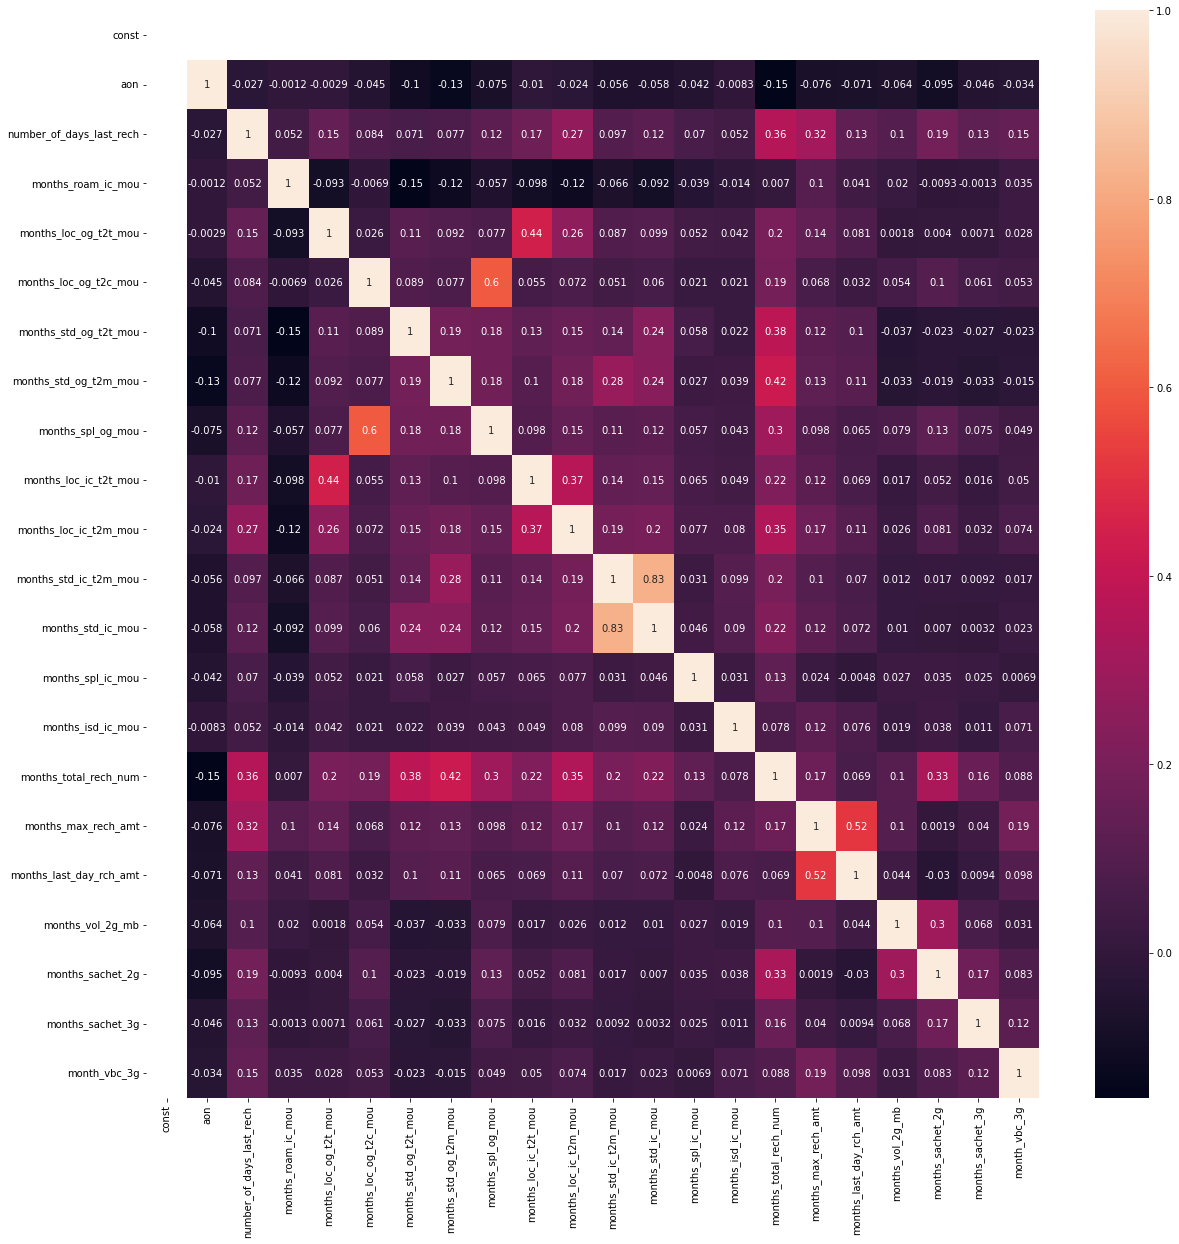

In [164]:
#let's check the correlation of all these features
plt.figure(figsize = (20,20))
sns.heatmap(X_train_rfe.corr(),annot = True)
plt.show()

**Correlation also looks good. We can't see any high value of correlation between features. Hence we can go ahead with this model as interpretable model.**

### Importance of features

In [165]:
(lr_model.params).sort_values(ascending = False)

number_of_days_last_rech    0.550060
months_std_og_t2t_mou       0.402916
months_std_og_t2m_mou       0.381360
months_last_day_rch_amt     0.348853
months_loc_ic_t2m_mou       0.308787
months_std_ic_mou           0.268498
months_sachet_2g            0.244795
months_max_rech_amt         0.208782
months_vol_2g_mb            0.185029
month_vbc_3g                0.177778
months_total_rech_num       0.177470
months_isd_ic_mou           0.157877
months_loc_ic_t2t_mou       0.128130
months_sachet_3g            0.122684
months_spl_ic_mou           0.118664
months_roam_ic_mou          0.094050
months_spl_og_mou           0.085863
months_loc_og_t2t_mou       0.063110
months_loc_og_t2c_mou      -0.101455
months_std_ic_t2m_mou      -0.113070
aon                        -0.568088
const                      -0.969444
dtype: float64

**The above table shows the importance of all the features. Top feature (number_of_days_last_rech) has highest importance followed by months_offnet_mou, etc.**
### Making Predictions

In [166]:
# Adding constant variable to test dataframe
X_test_m10 = sm.add_constant(X_test)

#using the attributes from train dataset which were used in the final model
X_test_m10 = X_test_m10[X_train_rfe.columns]

#making prediction using the final model
y_pred = lr_model.predict(X_test_m10)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

#renaming the column
y_pred_df.rename(columns = {0:'Probability'}, inplace = True)

#displaying the top 5 rows
y_pred_df.head()

,Probability
id,
32340,0.610273
44168,0.180249
10274,0.116878
3153,0.797131
55345,0.269362


In [167]:
#find the optimum cutoff
performance_df = pd.DataFrame(columns = ['Cutoff','Accuracy','Recall'])

df = pd.DataFrame()
df['true_value'] = y_test.churn_probability      # churned value
df['pred_prob_value'] = y_pred_df.Probability   # predicted churned probability

# The predicted churned probability remain fixed as no change in training data and model hyperpameters.
# The predicted churned label (0 or 1) changes with change in cut-off

for cutoff in [float(x)/100 for x in range(35, 45)]:
    col_name = 'pred_value_' + str(cutoff)
    df[col_name] = df['pred_prob_value'].map(lambda x: 1 if x > cutoff else 0) # Predicted churned based on cutoff value
    performance_df.loc[cutoff, 'Cutoff'] = cutoff
    performance_df.loc[cutoff, 'Accuracy'], performance_df.loc[cutoff, 'Recall'], performance_df.loc[cutoff, 'F1-Score'] = model_score(y_test, df[col_name])

In [168]:
performance_df

,Cutoff,Accuracy,Recall,F1-Score
0.35,0.35,0.689286,0.847262,0.310618
0.36,0.36,0.7,0.84438,0.317443
0.37,0.37,0.706905,0.835735,0.320265
0.38,0.38,0.716905,0.829971,0.326346
0.39,0.39,0.725238,0.827089,0.332176
0.40,0.4,0.734524,0.827089,0.339846
0.41,0.41,0.743333,0.821326,0.345874
0.42,0.42,0.751429,0.818444,0.352357
0.43,0.43,0.758571,0.818444,0.359039
0.44,0.44,0.76619,0.81268,0.364812


In [169]:
y_pred_df['predicted'] = y_pred_df.Probability.map( lambda x: 1 if x > 0.40 else 0)

In [170]:
y_pred_df.head()

,Probability,predicted
id,,
32340,0.610273,1
44168,0.180249,0
10274,0.116878,0
3153,0.797131,1
55345,0.269362,0


In [171]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test.churn_probability, y_pred_df.predicted)
confusion

array([[2798, 1055],
       [  60,  287]], dtype=int64)

In [172]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_test.churn_probability, y_pred_df.predicted)

0.7345238095238096

In [173]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

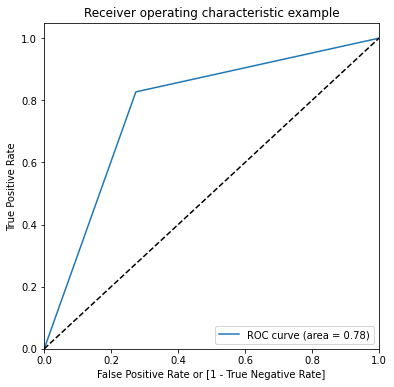

(array([0.        , 0.27381261, 1.        ]),
 array([0.        , 0.82708934, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [174]:
draw_roc(y_test.churn_probability, y_pred_df.predicted)

In [175]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
"{:2.2f}".format(metrics.roc_auc_score(y_test.churn_probability, y_pred_df.predicted))

'0.78'

## Conclusion:

1. Predictor Model:
    - To predict the customer churn in the best possible way, we have built 4 different models (Logistic Regression, Decision Tree, Random Forest and Adaboost).
    - As per the business understanding, we don't want to miss any customer who is going to churn. It is okay if we predict as churn for the customers who are not going to churn.
    - So basically the Recall/Sensitivity metrics plays the key role here instead of accuracy.
    - Out of all the 4 models, Logistic Regression provides the best result with recall of 82%. and accuracy of 73%.
    
2. Interpretable Model:
    - We have initiated the model building process with 30 features using RFE.
    - Validated the significance, correlation of all the feations and found the final model with 21 features.
    - As per buisness requirement, we need better Recall value so for that we have selected cutoff as 0.4.
    - Accuracy = 73.4%
    - Area Under Curve (AUC) = 0.78
    - Below are the features with higher importance:
        - number_of_days_last_rech
        - months_std_og_t2t_mou   
        - months_std_og_t2m_mou   
        - months_last_day_rch_amt 
        - months_loc_ic_t2m_mou   
        - months_std_ic_mou       
        - months_sachet_2g        
        - months_max_rech_amt     
        - months_vol_2g_mb        
        - month_vbc_3g            
        - months_total_rech_num   
        - months_isd_ic_mou       
        - months_loc_ic_t2t_mou   
        - months_sachet_3g        
        - months_spl_ic_mou       
        - months_roam_ic_mou      
        - months_spl_og_mou       
        - months_loc_og_t2t_mou   
        - months_loc_og_t2c_mou   
        - months_std_ic_t2m_mou   
        - aon                     
<hr></hr>

## Recommendations:

   - Important factors that Telecom company should monitor are mentioned above.
   - If the customers are not doing the recharge for long time then they are likely to churn.
   - Increase in std calls to the same or other network is an indicator that the customers will churn soon. The reason could be they are making more std calls which is charging them more. In that case providing std offers will hstop them from churn.
   - Recharge amount is very important factor to notice if it starts reducing month by month then it need to be looked as customer may not be happy with the services he is getting and he started recharging with less amount.
   - Customers who are with the company for long time are less likely to churn hence they are loyal customers.
   - If customer is using the services only for incoming calls and has stopped using outgoing calls then he is finding the services bit costly and may switch to network where incoming and outgoing services are at reasonable rate.
   - If internet speed that customer is getting is good, customer will finsh data soon and recharge it again but if network is poor and speed is not good then customer will not be able to finish it and will not recharge it multiple times. This is happening in case customer is using 2G network.
   - If the outgoing calls are getting reduced then it indicates that customer might churn due to high cost. Providing offers to such customers will help the company.

## Prediction on Test dataset for Kaggle

**The test dataset is available in different csv file. We need to perform the same steps which were performed for the train dataset. Let's import the test dataset and clean the data for the prediction.**

In [176]:
#load the data
churn_test = pd.read_csv('test (1).csv')

In [177]:
#show the top 5 rows
churn_test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [178]:
# Setting id as index as it is a unique identifier for a customer
churn_test = churn_test.set_index('id')

In [179]:
#checking the shape of the data
churn_test.shape

(30000, 170)

In [180]:
#let's check the null values
churn_test.isnull().sum()

circle_id                       0
loc_og_t2o_mou                316
std_og_t2o_mou                316
loc_ic_t2o_mou                316
last_date_of_month_6            0
last_date_of_month_7          202
last_date_of_month_8          367
arpu_6                          0
arpu_7                          0
arpu_8                          0
onnet_mou_6                  1169
onnet_mou_7                  1172
onnet_mou_8                  1675
offnet_mou_6                 1169
offnet_mou_7                 1172
offnet_mou_8                 1675
roam_ic_mou_6                1169
roam_ic_mou_7                1172
roam_ic_mou_8                1675
roam_og_mou_6                1169
roam_og_mou_7                1172
roam_og_mou_8                1675
loc_og_t2t_mou_6             1169
loc_og_t2t_mou_7             1172
loc_og_t2t_mou_8             1675
loc_og_t2m_mou_6             1169
loc_og_t2m_mou_7             1172
loc_og_t2m_mou_8             1675
loc_og_t2f_mou_6             1169
loc_og_t2f_mou

In [181]:
#lets impute missing values with '0' to match the column same as train dataset 
churn_test[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_data_6',
        'total_rech_data_7','total_rech_data_8']]=churn_test[['av_rech_amt_data_6','av_rech_amt_data_7',
    'av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8']].fillna(0, axis=1)

In [182]:
#Lets impute all these columns with '0' as they look important for model building
imp = ['max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
        'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7',
        'arpu_2g_8','night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
churn_test[imp]=churn_test[imp].replace(np.nan, 0)

In [183]:
#lets sum up all types of data recharge in the month - Feature Engineering
churn_test['total_rech_num_data_6'] = (churn_test['count_rech_2g_6']+churn_test['count_rech_3g_6']).astype(int)
churn_test['total_rech_num_data_7'] = (churn_test['count_rech_2g_7']+churn_test['count_rech_3g_7']).astype(int)
churn_test['total_rech_num_data_8'] = (churn_test['count_rech_2g_8']+churn_test['count_rech_3g_8']).astype(int)

#lets calculate total amount spent on recharging data(mobile internet) in the month
#multiply amount with number of times it was recharged for data 
churn_test['total_rech_amt_data_6'] = churn_test['total_rech_num_data_6']*churn_test['av_rech_amt_data_6']
churn_test['total_rech_amt_data_7'] = churn_test['total_rech_num_data_7']*churn_test['av_rech_amt_data_7']
churn_test['total_rech_amt_data_8'] = churn_test['total_rech_num_data_8']*churn_test['av_rech_amt_data_8']

#lets calculate total monthly recharge for data and call, so sum amounts spent on call and data recharge for the month.
churn_test['total_month_rech_6'] = churn_test['total_rech_amt_6']+churn_test['total_rech_amt_data_6']
churn_test['total_month_rech_7'] = churn_test['total_rech_amt_7']+churn_test['total_rech_amt_data_7']
churn_test['total_month_rech_8'] = churn_test['total_rech_amt_8']+churn_test['total_rech_amt_data_8']

In [184]:
churn_test.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_month_rech_6,total_month_rech_7,total_month_rech_8
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1692,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,103.0,90.0,60.0
70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17

In [185]:
churn_test.shape

(30000, 179)

In [186]:
(churn_test.isnull().sum()/len(churn_test)*100).sort_values(ascending = False)

date_of_last_rech_data_6    74.716667
date_of_last_rech_data_7    74.313333
date_of_last_rech_data_8    73.593333
loc_ic_t2m_mou_8             5.583333
std_og_t2t_mou_8             5.583333
roam_og_mou_8                5.583333
std_ic_t2t_mou_8             5.583333
std_og_t2c_mou_8             5.583333
loc_og_t2t_mou_8             5.583333
loc_ic_mou_8                 5.583333
loc_ic_t2f_mou_8             5.583333
loc_og_t2m_mou_8             5.583333
roam_ic_mou_8                5.583333
spl_og_mou_8                 5.583333
loc_og_t2f_mou_8             5.583333
loc_ic_t2t_mou_8             5.583333
loc_og_t2c_mou_8             5.583333
std_ic_t2m_mou_8             5.583333
isd_og_mou_8                 5.583333
og_others_8                  5.583333
std_ic_t2f_mou_8             5.583333
offnet_mou_8                 5.583333
std_og_t2m_mou_8             5.583333
std_ic_t2o_mou_8             5.583333
onnet_mou_8                  5.583333
std_ic_mou_8                 5.583333
spl_ic_mou_8

In [187]:
#lets handle top 3 columns with last recharge date. More than 70% data is missing hence will drop these columns.
churn_test.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],inplace=True,axis=1)

In [188]:
#last date of month is not providing any useful information. Hence dropping last date columns.
churn_test.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True,axis=1)

In [189]:
#converting remaining date object to datetime format
churn_test['date_of_last_rech_6'] = pd.to_datetime(churn_test.date_of_last_rech_6, format='%m/%d/%Y')
churn_test['date_of_last_rech_7'] = pd.to_datetime(churn_test.date_of_last_rech_7, format='%m/%d/%Y')
churn_test['date_of_last_rech_8'] = pd.to_datetime(churn_test.date_of_last_rech_8, format='%m/%d/%Y')

In [190]:
last_rech = churn_test[["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"]]

In [191]:
last_rech.isnull().sum()

date_of_last_rech_6     506
date_of_last_rech_7     533
date_of_last_rech_8    1161
dtype: int64

In [192]:
last_rech['last_Date_of_rech'] = last_rech['date_of_last_rech_8']

In [193]:
for i in range(last_rech.shape[0]):
    # if last recharge date not in month=8, then check month 7 and 6
    if pd.isnull(last_rech.iloc[i,2]): 
        if pd.isnull(last_rech.iloc[i,1]):
            last_rech.iloc[i,3] = last_rech.iloc[i,0] 
        else:
            last_rech.iloc[i,3] = last_rech.iloc[i,1]

In [194]:
last_rech.isnull().sum()

date_of_last_rech_6     506
date_of_last_rech_7     533
date_of_last_rech_8    1161
last_Date_of_rech        34
dtype: int64

In [195]:
churn_test['last_date_of_rech'] = last_rech['last_Date_of_rech']

In [196]:
#dropping the columns date_of_last_rech_8, date_of_last_rech_7, date_of_last_rech_6
churn_test.drop(["date_of_last_rech_8", "date_of_last_rech_7", "date_of_last_rech_6"], axis=1, inplace=True)

In [197]:
churn_test['base_date'] = datetime.date(2014, 9, 1)
churn_test['base_date'] = pd.to_datetime(churn_test['base_date'])

In [198]:
#subtracting the date with base date to get the number of days
churn_test['number_of_days_last_rech'] = churn_test['base_date'] - churn_test['last_date_of_rech']

In [199]:
churn_test['number_of_days_last_rech'] = churn_test['number_of_days_last_rech'].astype('timedelta64[D]')

In [200]:
churn_test[['number_of_days_last_rech']] = churn_test[['number_of_days_last_rech']].fillna(0.0, axis=1)

In [201]:
#now dropping the redundant date columns
churn_test.drop(['last_date_of_rech', 'base_date'], axis=1, inplace=True)

In [202]:
churn_test.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'], axis=1, inplace=True)

In [203]:
churn_test[month_Data] = churn_test[month_Data].fillna(0)

In [204]:
churn_test.drop(redundant_variables, axis=1, inplace = True)

In [205]:
churn_test.drop(['og_others_6'], axis=1, inplace = True)

In [206]:
#getting the average of june and july month data and deducting from august month
for i in range(len(list_month_features)):
    june = list_month_features[i][0]
    july = list_month_features[i][1]
    august = list_month_features[i][2]
  
    month_fea = 'months_' + june[:-2]
    churn_test[month_fea]=((churn_test[june]+churn_test[july])/2)- churn_test[august]

    #now we can drop the individual month features and all these columns are redundant
    churn_test.drop([june, july, august], axis=1, inplace=True)

In [207]:
#taking the average of jun, july month and deducting from august month data
churn_test['month_vbc_3g'] = ((churn_test['jun_vbc_3g'] + churn_test['jul_vbc_3g'])/2) - churn_test['aug_vbc_3g']

In [208]:
#few columns had more missing values and are not providing any useful information. Hence dropping all these features.
churn_test.drop(['jun_vbc_3g', 'jul_vbc_3g','aug_vbc_3g','months_total_rech_data','months_max_rech_data','months_count_rech_2g',
              'months_count_rech_3g','months_av_rech_amt_data','months_arpu_3g','months_arpu_2g','months_night_pck_user',
              'months_fb_user','months_total_rech_num_data','months_total_rech_amt_data','months_total_month_rech'], axis=1, inplace=True)

In [209]:
#applying the function on the dataset
churn_test = churn_test.apply(cap_outliers, axis=0)

In [210]:
churn_test[X_train_col]= scaler.transform(churn_test[X_train_col])

### Making prediction using final Logistic Regression model

In [211]:
# Adding constant variable to test dataframe
X_test_kaggle = sm.add_constant(churn_test)

#using the attributes from train dataset which were used in the final model
X_test_kaggle = X_test_kaggle[X_train_rfe.columns]

#making prediction using the final model
y_pred = lr_model.predict(X_test_kaggle)

# Converting y_pred to a dataframe which is an array
y_pred_kaggle = pd.DataFrame(y_pred)

#renaming the column
y_pred_kaggle.rename(columns = {0:'Probability'}, inplace = True)

#displaying the top 5 rows
y_pred_kaggle.head()

,Probability
id,
69999,0.245674
70000,0.235593
70001,0.286629
70002,0.423708
70003,0.123357


In [212]:
y_pred_kaggle['churn_probability'] = y_pred_kaggle.Probability.map( lambda x: 1 if x > 0.9 else 0)

In [213]:
y_pred_kaggle = y_pred_kaggle.reset_index()

In [214]:
output = y_pred_kaggle[['id','churn_probability']]
output.to_csv('Submission.csv',index=False)

## I have submitted the submission file on Kaggle platform with the file name *Vaibhav Shukla_Pankaj Kumar Sharma.csv*. As the maximum number of submission were reached, I couldn't upload the new file with different name also the previous file had best results so couldn't replace it. The same prediction file is uploaded on the platform as well.